## Import libraries ##

In [13]:
# Import libraries
import pandas as pd
import numpy as np
import datetime
import random 
from collections import Counter
import scipy.stats as st
from scipy.stats import kurtosistest, chi2, linregress, bartlett, ttest_ind, ttest_1samp, pearsonr, spearmanr, f_oneway, kruskal
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

from sklearn.neighbors import KernelDensity
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, plot_confusion_matrix, SCORERS
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.neighbors import NearestNeighbors

import torch
import torch.nn as nn

import queue

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

import sys
import os
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'

sys.path.append('/Users/riccardo/Documents/GitHub/COVID19Classification/')
from Modules import Parameters, DataPreprocessing as DP, Classification as CL, CustomFunctions as CF
from Modules import CustomClasses as cc

## Colors

In [14]:
# Palette 1: colorful
pink_pal1 = '#E38A8A'
light_green_pal1 = '#A3F0A3'
green_pal1 = '#7FB285'
pine_green_pal1 = '#136F63'
violet_pal1 = '#A888BF'
light_red_purp_pal1 = '#FF616D'
red_purp_pal1 = '#F73B5C' #'#D83A56'
light_blue_pal1 = '#3C8DAD'
dark_blue_pal1 = '#125D98'
orange_pal1 = '#F5A962'
yellow_pal1 = '#FFD966'
lavander_pal1 = '#D5C6E0'
dark_liver_pal1 = '#56494C'
dark_purple_pal1 = '#30011E'
grey_green_pal1 = '#5B7B7A'
coral_pal1 = '#FF8360'
dark_coral_pal1 = '#FF6F47'
rose_pal1 = '#FF69A5'
electricblue_pal1 = '#7DF9FF'
dark_dark_blue_pal1 = '#0B385B'
dark_blue_green_pal1 = '#40b5a0'

# Under consideration...
grey_1 = '#AAAAAA'
grey_2 = '#DDDDDD'

# color scheme
color_control = CF.lighten_color(green_pal1, 0.8)
color_control2 = lavander_pal1
color_immunecells = orange_pal1
color_cytokines = pink_pal1 #red_purp_pal1
color_bloodtests1 = lavander_pal1
color_bloodtests2 = violet_pal1
color_scores = light_red_purp_pal1 #coral_pal1
color_demographics = light_blue_pal1 #pine_green_pal1
color_0 = dark_blue_pal1
color_0_light = light_blue_pal1
color_1 = red_purp_pal1
color_1_light = light_red_purp_pal1
color_background = CF.lighten_color(grey_2, 0.6)

## Parameters

In [15]:
## Multivariate sets
allinput_set = Parameters.allinput_set
immunecells_set = Parameters.immunecells_set
demographics_set = Parameters.demographics_set
cytokines_set = Parameters.cytokines_set 
biomarkers_set = Parameters.biomarkers_set
FC_set = Parameters.FC_set
Dem_set = Parameters.Dem_set
CK_set = Parameters.CK_set
BM_set =  Parameters.BM_set
scores_set = Parameters.scores_set
comorbidities_set = Parameters.comorbidities_set

## Targets
target_train = Parameters.train_target
target_test = Parameters.test_target

## Age
lower_bound = 30 #Parameters.age_min
upper_bound = 100 #Parameters.age_max

## Delta onset
lower_bound_donset = 0 #Parameters.donset_min
upper_bound_donset = 30 #Parameters.donset_max

## Minimum NPV
min_NPV_Models = Parameters.min_NPV_Models
min_NPV = Parameters.min_NPV

## Correlation threshod
corr_th_univ = Parameters.corr_th_univ

## Min % no nans per column
perc_nonans = Parameters.perc_nonans
perc_nonans_univ = Parameters.perc_nonans_univ

## Nan masking row-wise
do_nan_masking = Parameters.do_nan_masking
do_nan_masking_univ = Parameters.do_nan_masking_univ
nan_masking = Parameters.nan_masking
do_nan_masking_groupwise = Parameters.do_nan_masking_groupwise

## Reference time
ref_time = Parameters.ref_time

## N samples for average
N_av = Parameters.N_av

## Imputation
imputation_method = Parameters.imputation_method
imputation_method_univ = Parameters.imputation_method_univ

## Standardization
std_method = Parameters.std_method

## PCA % var. threshold
pc_var_th = Parameters.pca_var_threshold

## Train-test
test_size = Parameters.test_size

## Plot
plot_minNPV_models = Parameters.plot_minNPV_models

## Feature selection
use_manual_selection = Parameters.use_manual_selection

## Paths
path_datasets = Parameters.path_datasets
path_results = Parameters.path_results
path_figures = Parameters.path_figures
exp_description = Parameters.exp_description
exp_univ_description = Parameters.exp_univ_description
exp_multiv_description = Parameters.exp_multiv_description
foldername_univ = Parameters.foldername_univ
foldername_multiv = Parameters.foldername_multiv

## Dataset
use_CCIMasked_dataset = Parameters.use_CCIMasked_dataset

## Regulariser
find_regulariser_before_average = Parameters.find_regulariser_before_average

## Run experiments
run_experiments = True

## Import and prepare datasets

In [16]:
DataInpatients, DataOutpatients, DataControlpatients = DP.data_preprocessing(return_allfeatures=True, return_controlset=True)

# Mask data by target
mask = pd.notnull(DataInpatients[target_train].values) & pd.notnull(DataInpatients[target_test].values)
DataInpatients = DataInpatients.loc[mask,:]

DataInpatients.shape, DataOutpatients.shape, DataControlpatients.shape

Original shape inpatients data: (826, 94)
Original shape outpatients data: (462, 98)


((790, 97), (367, 97), (95, 97))

## FC sets

In [17]:
# Immune cells
immunecells_set4 = ['NK/uL', 'B CD19/uL', 'T CD3/uL', 'T CD4/uL', '% T CD4 HLADR POS', 'T CD8/uL', '% T CD8 HLADR POS']
immunecells_set5 = ['WBC/uL', 'Mono/uL', 'MONO DR IFI', 'Mono DR %', 'Linfo/uL', 'LRTE/uL', 'LRTE % dei CD4']
immunecells_set45 = immunecells_set4 + immunecells_set5

# Histograms

## $\Delta t_{\mathrm{ons}}$

In [18]:
lw = 1.2

time_col = 'delta_onset'
set_yticks = True
color_ref = 'black'

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = .5

Quartiles COVID-19 set:
7.0 9.0 12.0


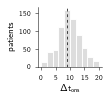

In [19]:
magnification = 0.55
ratio = 2.2/2.4
CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                        fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                        tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True
mec = 'white'
ms = 9
mew = 0.15

color = grey_2 #CF.lighten_color('black', 1.)
color_edge = grey_2
bins = np.arange(-2, 35, 2)
v = DataInpatients['delta_onset'].dropna().values
print('Quartiles COVID-19 set:')
print(np.quantile(v, 0.25), np.quantile(v, 0.5), np.quantile(v, 0.75))
y_hist, _, _ = plt.hist(v, bins=bins, color=color, alpha=0)
plt.hist(v, density=False, bins=bins, color=color, edgecolor='white', alpha=1., linewidth=0.9)
x_min, x_max = min(bins), max(bins)
plt.xlim([x_min, x_max])
plt.ylabel('patients')
plt.xlabel('$\mathrm{\Delta t_{ons}}$')
plt.xticks([0, 5, 10, 15, 20])
plt.xlim([-1, 21])
#plt.ylim([0, 0.11])
#plt.yticks([0, 0.05, 0.1])
plt.grid(False)

plt.axvline(np.quantile(v, 0.5), lw=0.7, color='black', ls='--', dashes=(4, 4))

bandwidth = 1.
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(v.reshape(-1, 1))
max_val = max(v)
min_val = min(v)
x = np.linspace(-3*bandwidth + min_val, max_val + 3*bandwidth, 1000)
e = kde.score_samples(x.reshape(-1,1))
color = dark_blue_pal1
y_est = np.exp(e)
y_est = max(y_hist-1) * y_est/(max(y_est))
#plt.plot(x, y_est, color=color, lw=lw, label='density\nprofile')
#plt.legend()

saving_str = path_figures + 'cases_vs_donset.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## WHO

In [20]:
lw = 1.2

set_yticks = True
color_ref = 'black'

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = .5

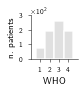

In [21]:
magnification = 0.43
ratio = 2.4/2.2
CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                        fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                        tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

color = grey_2
color_edge = grey_2
bins = np.arange(-0.5, 6.5, 1)
v = DataInpatients['WHO'].dropna().values
v[v==0] = 1
v[v==5] = 4
y_hist, _, _ = plt.hist(v, bins=bins, color=color, alpha=0)
plt.hist(v, density=False, bins=bins, color=color, edgecolor='white', alpha=0.9, linewidth=1.5)
x_min, x_max = min(bins), max(bins)
plt.xlim([x_min, x_max])
plt.ylabel('n. patients')
plt.xlabel('WHO')
plt.xticks([1, 2, 3, 4])
plt.xlim([0., 5])
plt.yticks([0, 100, 200, 300])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.grid(False)

bandwidth = 1.
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(v.reshape(-1, 1))
max_val = max(v)
min_val = min(v)
x = np.linspace(-3*bandwidth + min_val, max_val + 3*bandwidth, 1000)
e = kde.score_samples(x.reshape(-1,1))
color = dark_blue_pal1
y_est = np.exp(e)
y_est = max(y_hist-1) * y_est/(max(y_est))
saving_str = path_figures + 'cases_vs_WHO.pdf'
#plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## Age

Quartiles COVID-19 set:
58.81656399726215 68.30527036276523 76.5927446954141
Quartiles control set:
36.0 51.0 61.0
/Users/riccardo/Documents/GitHub/COVID19Classification/Figures/inpatients_vs_age.pdf


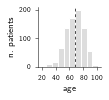

In [22]:
magnification = 0.7
ratio = 2.2/2.5
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=10, ylabelsize=8, xlabelsize=8, tex=True, axes_lines_w=0.5, lines_w=0.5)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()
print('Quartiles COVID-19 set:')
print(np.quantile(Data['age'], 0.25), np.quantile(Data['age'], 0.5), np.quantile(Data['age'], 0.75))
print('Quartiles control set:')
print(np.quantile(Data_c['age'], 0.25), np.quantile(Data_c['age'], 0.5), np.quantile(Data_c['age'], 0.75))

magnification = 0.55
ratio = 2.2/2.4
CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                        fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                        tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True
mec = 'white'
ms = 9
mew = 0.15


fig, ax = plt.subplots()

x1 = Data['age']
x2 = Data_c['age']
x_1_min, x_1_max = 10, 110
bins = np.linspace(x_1_min, x_1_max, 13)

color = grey_2
ax.hist(x1, bins,
        alpha=1., 
        color=color, 
        density=False,
        edgecolor='white',
        label='COVID-19')

plt.axvline(np.quantile(Data['age'], 0.5), lw=0.7, color='black', ls='--', dashes=(4, 4))

ax.set_xlabel('age')
ax.set_xticks([20, 40, 60, 80, 100])
ax.set_xlim([15, 105])
ax.set_ylabel('n. patients')
saving_str = path_figures + 'inpatients_vs_age' + '.pdf'
print(saving_str)
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

Quartiles COVID-19 set:
58.81656399726215 68.30527036276523 76.5927446954141
Quartiles control set:
36.0 51.0 61.0
/Users/riccardo/Documents/GitHub/COVID19Classification/Figures/cases_vs_age.pdf


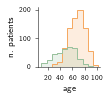

In [23]:
magnification = 0.7
ratio = 2.2/2.5
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=10, ylabelsize=8, xlabelsize=8, tex=True, axes_lines_w=0.5, lines_w=0.5)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()
print('Quartiles COVID-19 set:')
print(np.quantile(Data['age'], 0.25), np.quantile(Data['age'], 0.5), np.quantile(Data['age'], 0.75))
print('Quartiles control set:')
print(np.quantile(Data_c['age'], 0.25), np.quantile(Data_c['age'], 0.5), np.quantile(Data_c['age'], 0.75))

magnification = 0.55
ratio = 2.2/2.4
CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                        fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                        tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True
mec = 'white'
ms = 9
mew = 0.15


fig, ax = plt.subplots()

x1 = Data['age']
x2 = Data_c['age']
x_1_min, x_1_max = 10, 110
bins = np.linspace(x_1_min, x_1_max, 13)

color = color_immunecells
ax.hist(x1, bins,
        alpha=0.2, 
        histtype='stepfilled',
        color=color, 
        density=False,
        edgecolor='white',
        label='COVID-19')
ax.hist(x1, bins,
        alpha=1., 
        histtype='step',
        edgecolor=color,
        density=False,
        facecolor='None')

color = color_control
ax.hist(x2, bins,
        alpha=.2, 
        histtype='stepfilled',
        color=color,
        density=False,
        edgecolor=color, 
        label='control')
ax.hist(x2, bins,
        alpha=1., 
        histtype='step',
        edgecolor=color,
        density=False,
        facecolor='None')

ax.set_xlabel('age')
ax.set_xticks([20, 40, 60, 80, 100])
ax.set_xlim([5, 105])
ax.set_ylabel('n. patients')
saving_str = path_figures + 'cases_vs_age' + '.pdf'
print(saving_str)
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## Age - OutP vs ControlP

/Users/riccardo/Documents/GitHub/COVID19Classification/Figures/cases_vs_age_outp.pdf


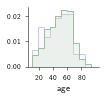

In [24]:
Data_c = DataOutpatients.copy()
Data_h = DataControlpatients.copy()
magnification = 0.55
ratio = 2.2/2.4
CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                        fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                        tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True
mec = 'white'
ms = 9
mew = 0.15


fig, ax = plt.subplots()

x1 = Data_h['age']
x2 = Data_c['age']
x_1_min, x_1_max = 10, 110
bins = np.linspace(x_1_min, x_1_max, 13)

color = color_control2 
ax.hist(x1, bins,
        alpha=.1,
        histtype='stepfilled',
        color=color,
        density=True,
        edgecolor=color, 
        label='control')
ax.hist(x1, bins,
        alpha=1.,
        histtype='step',
        edgecolor=color,
        density=True,
        facecolor='None')

color = color_control
ax.hist(x2, bins,
        alpha=0.15, 
        histtype='stepfilled',
        color=color, 
        density=True,
        edgecolor='white',
        label='COVID-19')
ax.hist(x2, bins,
        alpha=1.,
        histtype='step',
        edgecolor=color,
        density=True,
        facecolor='None')

ax.set_xlabel('age')
ax.set_xticks([20, 40, 60, 80])
ax.set_xlim([5, 105])
#ax.set_ylabel('patients')
saving_str = path_figures + 'cases_vs_age_outp' + '.pdf'
print(saving_str)
#plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

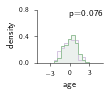

In [54]:
sc = StandardScaler()
pt = PowerTransformer()

variable = 'age'

magnification = 0.55
ratio = 2.2/2.5
CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                            fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                            tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True

fig, ax = plt.subplots()

x1 = Data_h[variable].dropna().to_numpy()
x2 = Data_c[variable].dropna().to_numpy()
mw_pval = st.mannwhitneyu(x1, x2)[1]

x1 = pt.fit_transform(sc.fit_transform(x1.reshape(-1,1))).reshape(-1,)
x2 = pt.transform(sc.transform(x2.reshape(-1,1))).reshape(-1,)

bins = np.linspace(-4.5, 4.5, 18)

color = color_control2 
ax.hist(x1, bins,
        alpha=.1,
        histtype='stepfilled',
        color=color,
        density=True,
        edgecolor=color, 
        label='control')
ax.hist(x1, bins,
        alpha=1.,
        histtype='step',
        edgecolor=color,
        density=True,
        facecolor='None')

color = color_control
ax.hist(x2, bins,
        alpha=0.15, 
        histtype='stepfilled',
        color=color, 
        density=True,
        edgecolor='white',
        label='COVID-19')
ax.hist(x2, bins,
        alpha=1.,
        histtype='step',
        edgecolor=color,
        density=True,
        facecolor='None')

ax.set_xlabel('%s' % CF.change_names_2([variable], units=False)[0])
ax.set_ylabel('density')
ax.set_xticks([-3, 0, 3])
ax.set_xlim([-5., 5.])
ax.set_yticks([0, 0.4, 0.8])
ax.set_ylim([0, 0.8])
p_val_str = 'p=%.3f' % mw_pval
plt.text(.99, .99, p_val_str, ha='right', va='top', transform=ax.transAxes)

saving_str = path_figures + 'cases_vs_age_outp' + '.pdf'
#print(saving_str)
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

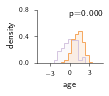

In [55]:
sc = StandardScaler()
pt = PowerTransformer()

variable = 'age'

magnification = 0.55
ratio = 2.2/2.5
CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                            fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                            tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True

fig, ax = plt.subplots()

x1 = Data_h[variable].dropna().to_numpy()
x2 = Data[variable].dropna().to_numpy()
mw_pval = st.mannwhitneyu(x1, x2)[1]

x1 = pt.fit_transform(sc.fit_transform(x1.reshape(-1,1))).reshape(-1,)
x2 = pt.transform(sc.transform(x2.reshape(-1,1))).reshape(-1,)

bins = np.linspace(-4.5, 4.5, 18)

color = color_control2 
ax.hist(x1, bins,
        alpha=.1,
        histtype='stepfilled',
        color=color,
        density=True,
        edgecolor=color, 
        label='control')
ax.hist(x1, bins,
        alpha=1.,
        histtype='step',
        edgecolor=color,
        density=True,
        facecolor='None')

color = color_immunecells
ax.hist(x2, bins,
        alpha=0.15, 
        histtype='stepfilled',
        color=color, 
        density=True,
        edgecolor='white',
        label='COVID-19')
ax.hist(x2, bins,
        alpha=1.,
        histtype='step',
        edgecolor=color,
        density=True,
        facecolor='None')

ax.set_xlabel('%s' % CF.change_names_2([variable], units=False)[0])
ax.set_ylabel('density')
ax.set_xticks([-3, 0, 3])
ax.set_xlim([-5., 5.])
ax.set_yticks([0, 0.4, 0.8])
ax.set_ylim([0, 0.8])
p_val_str = 'p=%.3f' % mw_pval
plt.text(.99, .99, p_val_str, ha='right', va='top', transform=ax.transAxes)

saving_str = path_figures + 'cases_vs_age_inphp' + '.pdf'
#print(saving_str)
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## Sex - OutP vs ControlP

53 42


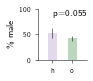

In [63]:
CF.SetPlotParams(magnification=magnification*0.86, ratio=ratio, 
                        fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                        tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True

key = 'sex'
x1 = Data_h[key].dropna().to_numpy()
x2 = Data_c[key].dropna().to_numpy()
count = np.array([np.sum(x1==1), np.sum(x2==1)])
nobs = np.array([np.sum(pd.notnull(x1)), np.sum(pd.notnull(x2==1))])
z_pval = proportions_ztest(count=count, nobs=nobs)[1]

frac_male_1 = sum(x1==0)/sum(pd.notnull(x1))
ci1_low, ci1_up = proportion_confint(sum(x1==0), sum(pd.notnull(x1)), alpha=0.05, method='binom_test')
frac_male_2 = sum(x2==0)/sum(pd.notnull(x2))
ci2_low, ci2_up = proportion_confint(sum(x2==0), sum(pd.notnull(x2)), alpha=0.05, method='binom_test')
perc_male_1 = round(frac_male_1*100)
yerr_perc_male_1 = np.array([(frac_male_1 - ci1_low)*100, (ci1_up - frac_male_1)*100]).reshape(-1,1)
perc_male_2 = round(frac_male_2*100)
yerr_perc_male_2 = np.array([(frac_male_2 - ci2_low)*100, (ci2_up - frac_male_2)*100]).reshape(-1,1)
print(perc_male_1, perc_male_2)

fig, ax = plt.subplots()

widths = 0.3
lines_w = 0.5
capsize = 0
ax.bar(0, perc_male_1, yerr=yerr_perc_male_1, color=color_control2, alpha=0.65, width=widths, lw=lines_w, capsize=capsize)
ax.bar(0.7, perc_male_2, yerr=yerr_perc_male_2, color=color_control, alpha=0.65, width=widths, lw=lines_w, capsize=capsize)
p_val_str = 'p=%.3f' % z_pval
plt.text(.99, .99, p_val_str, ha='right', va='top', transform=ax.transAxes)

plt.yticks([0, 50, 100])
plt.ylim([0, 100])
plt.xticks([0, 0.7], ['h', 'o'], )
plt.xlim([-0.5, 1.2])

plt.ylabel('\% male')

saving_str = path_figures + 'sex_outp' + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

53 66


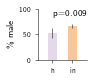

In [64]:
CF.SetPlotParams(magnification=magnification*0.86, ratio=ratio, 
                        fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                        tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
mpl.rc('text', usetex = True)
mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.bottom'] = True

key = 'sex'
x1 = Data_h[key].dropna().to_numpy()
x2 = Data[key].dropna().to_numpy()
count = np.array([np.sum(x1==1), np.sum(x2==1)])
nobs = np.array([np.sum(pd.notnull(x1)), np.sum(pd.notnull(x2==1))])
z_pval = proportions_ztest(count=count, nobs=nobs)[1]

frac_male_1 = sum(x1==0)/sum(pd.notnull(x1))
ci1_low, ci1_up = proportion_confint(sum(x1==0), sum(pd.notnull(x1)), alpha=0.05, method='binom_test')
frac_male_2 = sum(x2==0)/sum(pd.notnull(x2))
ci2_low, ci2_up = proportion_confint(sum(x2==0), sum(pd.notnull(x2)), alpha=0.05, method='binom_test')
perc_male_1 = round(frac_male_1*100)
yerr_perc_male_1 = np.array([(frac_male_1 - ci1_low)*100, (ci1_up - frac_male_1)*100]).reshape(-1,1)
perc_male_2 = round(frac_male_2*100)
yerr_perc_male_2 = np.array([(frac_male_2 - ci2_low)*100, (ci2_up - frac_male_2)*100]).reshape(-1,1)
print(perc_male_1, perc_male_2)

fig, ax = plt.subplots()

widths = 0.3
lines_w = 0.5
capsize = 0
ax.bar(0, perc_male_1, yerr=yerr_perc_male_1, color=color_control2, alpha=0.65, width=widths, lw=lines_w, capsize=capsize)
ax.bar(0.7, perc_male_2, yerr=yerr_perc_male_2, color=color_immunecells, alpha=0.65, width=widths, lw=lines_w, capsize=capsize)
p_val_str = 'p=%.3f' % z_pval
plt.text(.99, .99, p_val_str, ha='right', va='top', transform=ax.transAxes)

plt.yticks([0, 50, 100])
plt.ylim([0, 100])
plt.xticks([0, 0.7], ['h', 'in'], )
plt.xlim([-0.5, 1.2])

plt.ylabel('\% male')

saving_str = path_figures + 'sex_inphp' + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## FC set - OutP vs ControlP

NK/uL


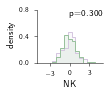

B CD19/uL


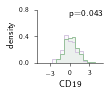

T CD3/uL


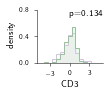

T CD4/uL


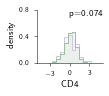

% T CD4 HLADR POS


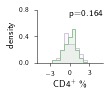

T CD8/uL


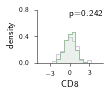

% T CD8 HLADR POS


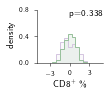

WBC/uL


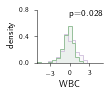

NeutroBaEu/uL


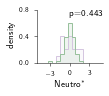

Mono/uL


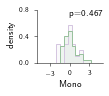

MONO DR IFI


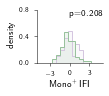

Mono DR %


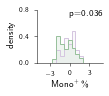

Linfo/uL


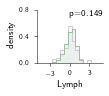

LRTE/uL


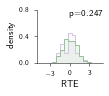

LRTE % dei CD4


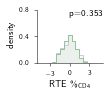

In [58]:
sc = StandardScaler()
pt = PowerTransformer()

for idx, variable in enumerate(immunecells_set):
    print(variable)
    
    magnification = 0.55
    ratio = 2.2/2.5
    CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                                fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                                tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
    mpl.rc('text', usetex = True)
    mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.bottom'] = True

    fig, ax = plt.subplots()
    
    x1 = Data_h[variable].dropna().to_numpy()
    x2 = Data_c[variable].dropna().to_numpy()
    mw_pval = st.mannwhitneyu(x1, x2)[1]

    x1 = pt.fit_transform(sc.fit_transform(x1.reshape(-1,1))).reshape(-1,)
    x2 = pt.transform(sc.transform(x2.reshape(-1,1))).reshape(-1,)

    bins = np.linspace(-5, 5, 18)

    color = color_control2 
    ax.hist(x1, bins,
            alpha=.1,
            histtype='stepfilled',
            color=color,
            density=True,
            edgecolor=color, 
            label='control')
    ax.hist(x1, bins,
            alpha=1.,
            histtype='step',
            edgecolor=color,
            density=True,
            facecolor='None')

    color = color_control
    ax.hist(x2, bins,
            alpha=0.15, 
            histtype='stepfilled',
            color=color, 
            density=True,
            edgecolor='white',
            label='COVID-19')
    ax.hist(x2, bins,
            alpha=1.,
            histtype='step',
            edgecolor=color,
            density=True,
            facecolor='None')

    ax.set_xlabel('%s' % CF.change_names_2([variable], units=False)[0])
    ax.set_ylabel('density')
    ax.set_xticks([-3, 0, 3])
    ax.set_xlim([-5., 5.])
    ax.set_yticks([0, 0.4, 0.8])
    ax.set_ylim([0, 0.8])
    p_val_str = 'p=%.3f' % mw_pval
    plt.text(.99, .99, p_val_str, ha='right', va='top', transform=ax.transAxes)

    saving_str = path_figures + 'cases_vs_FC#%d_outp' % idx + '.pdf'
    #print(saving_str)
    plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
    plt.show()

NK/uL


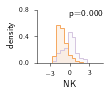

B CD19/uL


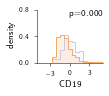

T CD3/uL


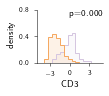

T CD4/uL


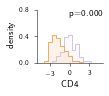

% T CD4 HLADR POS


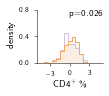

T CD8/uL


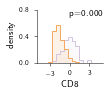

% T CD8 HLADR POS


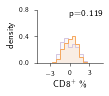

WBC/uL


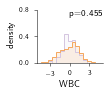

NeutroBaEu/uL


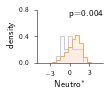

Mono/uL


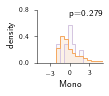

MONO DR IFI


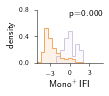

Mono DR %


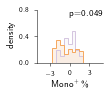

Linfo/uL


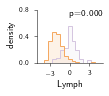

LRTE/uL


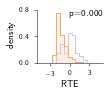

LRTE % dei CD4


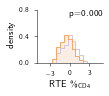

In [59]:
sc = StandardScaler()
pt = PowerTransformer()

for idx, variable in enumerate(immunecells_set):
    print(variable)
    
    magnification = 0.55
    ratio = 2.2/2.5
    CF.SetPlotParams(magnification=magnification, ratio=ratio, 
                                fontsize=fontsize, ylabelsize=ylabelsize, xlabelsize=xlabelsize, 
                                tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w)
    mpl.rc('text', usetex = True)
    mpl.rc('text.latex', preamble=r'\usepackage{sfmath}')
    mpl.rcParams['axes.spines.right'] = False
    mpl.rcParams['axes.spines.top'] = False
    mpl.rcParams['axes.spines.left'] = True
    mpl.rcParams['axes.spines.bottom'] = True

    fig, ax = plt.subplots()
    
    x1 = Data_h[variable].dropna().to_numpy()
    x2 = Data[variable].dropna().to_numpy()
    mw_pval = st.mannwhitneyu(x1, x2)[1]

    x1 = pt.fit_transform(sc.fit_transform(x1.reshape(-1,1))).reshape(-1,)
    x2 = pt.transform(sc.transform(x2.reshape(-1,1))).reshape(-1,)
    
    bins = np.linspace(-5, 5, 18)

    color = color_control2 
    ax.hist(x1, bins,
            alpha=.1,
            histtype='stepfilled',
            color=color,
            density=True,
            edgecolor=color, 
            label='control')
    ax.hist(x1, bins,
            alpha=1.,
            histtype='step',
            edgecolor=color,
            density=True,
            facecolor='None')

    color = color_immunecells
    ax.hist(x2, bins,
            alpha=0.15, 
            histtype='stepfilled',
            color=color, 
            density=True,
            edgecolor='white',
            label='COVID-19')
    ax.hist(x2, bins,
            alpha=1.,
            histtype='step',
            edgecolor=color,
            density=True,
            facecolor='None')

    ax.set_xlabel('%s' % CF.change_names_2([variable], units=False)[0])
    ax.set_ylabel('density')
    ax.set_xticks([-3, 0, 3])
    ax.set_xlim([-5., 5.])
    ax.set_yticks([0, 0.4, 0.8])
    ax.set_ylim([0, 0.8])
    p_val_str = 'p=%.3f' % mw_pval
    plt.text(.99, .99, p_val_str, ha='right', va='top', transform=ax.transAxes)

    saving_str = path_figures + 'cases_vs_FC#%d_inphp' % idx + '.pdf'
    #print(saving_str)
    plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
    plt.show()

# Summary tables

### Small table

In [35]:
# immunecells_set45, demographics, prog_scores_2, low_VIF_cy_sel_0, blood_tests

column_set_dict = {'FC': immunecells_set,
                   'CK': cytokines_set, 
                   'BM': biomarkers_set, 
                   'C': immunecells_set,}

table_dict1 = {'N': [], 'sex (female)': [], 'age [Q2(Q1-Q3)]': [], 'd. onset [Q2(Q1-Q3)]': [], 'CCI<2': [], 'NANs': []}
table_dict2 = {'SOFA>1': [], 'NEWS>4': [], 'qCSI>6': [], '4C>8': [], 'WHO>2': [], 'OTI+death': []}

for set_key in column_set_dict.keys():
    
    table_dict = {}
    column_set = column_set_dict[set_key]
    columns = demographics_set + column_set + scores_set + ['IOT+death', 'WHO']
    if set_key=='C':
        Data = DataOutpatients[columns].copy()
    else:
        Data = DataInpatients[columns].copy()
    mask = 100*np.sum(Data[column_set].isnull(), axis=1)/len(column_set)<=50
    Data = Data.loc[mask,:]
    # first row
    table_dict1["N"].append(Data.shape[0])
    table_dict1["sex (female)"].append("%.1f%%" % (np.nansum(Data["sex"])/np.sum(Data["sex"].notnull())*100))
    table_dict1["age [Q2(Q1-Q3)]"].append("%.f(%.f-%.f)" % (np.nanquantile(Data["age"],0.5), np.nanquantile(Data["age"],0.25), np.nanquantile(Data["age"],0.75)))
    table_dict1["d. onset [Q2(Q1-Q3)]"].append("%.f(%.f-%.f)" % (np.nanquantile(Data["delta_onset"],0.5), np.nanquantile(Data["delta_onset"],0.25), np.nanquantile(Data["delta_onset"],0.75)))
    table_dict1["CCI<2"].append("%.1f%%" % (np.nansum(Data["CCI (charlson comorbidity index)"]<2)/np.sum(Data["CCI (charlson comorbidity index)"].notnull())*100))
    table_dict1["NANs"].append("%.1f%%" % (Data[column_set].isnull().sum().sum()/Data[column_set].size*100))
    # second row
    table_dict2["SOFA>1"].append("%.1f%%" % (np.nansum(Data["SOFA"]>1)/np.sum(Data["SOFA"].notnull())*100))
    table_dict2["NEWS>4"].append("%.1f%%" % (np.nansum(Data["NEWS"]>4)/np.sum(Data["NEWS"].notnull())*100))
    table_dict2["qCSI>6"].append("%.1f%%" % (np.nansum(Data["qCSI"]>6)/np.sum(Data["qCSI"].notnull())*100))
    table_dict2["4C>8"].append("%.1f%%" % (np.nansum(Data["4 C score"]>8)/np.sum(Data["4 C score"].notnull())*100))
    table_dict2["WHO>2"].append("%.1f%%" % (np.nansum(Data["WHO"]>2)/np.sum(Data["WHO"].notnull())*100))
    table_dict2["OTI+death"].append("%.1f%%" % (np.nansum(Data["IOT+death"]>0)/np.sum(Data["IOT+death"].notnull())*100))

table_df1 = pd.DataFrame(table_dict1, index=['FC', 'CK', 'BM', 'C'])
table_df2 = pd.DataFrame(table_dict2, index=['FC', 'CK', 'BM', 'C'])

/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


In [37]:
table_df2

,SOFA>1,NEWS>4,qCSI>6,4C>8,WHO>2,OTI+death
FC,63.0%,28.3%,2.0%,48.7%,63.2%,24.1%
CK,61.4%,22.8%,0.7%,46.5%,58.0%,23.6%
BM,60.5%,24.0%,1.7%,51.0%,57.9%,20.8%
C,nan%,nan%,nan%,nan%,0.0%,0.0%


### Big table

In [27]:
Data_l = DataInpatients.copy()

Data_l['control'] = 0
Data_c = DataOutpatients.copy()
Data_c['control'] = 1
Data_complete = pd.concat([Data_l, Data_c], ignore_index=True)
Data_complete.reset_index(drop=True, inplace=True)

## define masks
age_thr = 70
donset_th = 10
group_masks = {}
# control
control_mask = Data_complete['control']==1
mask_control_age_l = (control_mask) & (Data_complete['age']<age_thr)
mask_control_age_h = (control_mask) & (Data_complete['age']>=age_thr)
group_masks['control'] = control_mask
group_masks['control_age_l'] = mask_control_age_l
group_masks['control_age_h'] = mask_control_age_h
# covid
covid_mask = Data_complete['control']==0
mask_covid_age_l = (covid_mask) & (Data_complete['age']<age_thr)
mask_covid_age_h = (covid_mask) & (Data_complete['age']>=age_thr)
mask_covid_donset_l = (covid_mask) & (Data_complete['delta_onset']<=donset_th)
mask_covid_donset_h = (covid_mask) & (Data_complete['delta_onset']>donset_th)
group_masks['covid'] = covid_mask
group_masks['covid_age_l'] = mask_covid_age_l
group_masks['covid_age_h'] = mask_covid_age_h
group_masks['covid_donset_l'] = mask_covid_donset_l
group_masks['covid_donset_h'] = mask_covid_donset_h
# covid who
mask_covid_who_02 = (covid_mask) & ((0<=Data_complete['WHO']) & (Data_complete['WHO']<=2))
mask_covid_who_35 = (covid_mask) & (Data_complete['WHO']>=3)
group_masks['covid_who_02'] = mask_covid_who_02
group_masks['covid_who_45'] = mask_covid_who_35

## Demographics
description_dict = {}
name = 'Number'
values = []
for group_mask in group_masks.keys():
    mask = (group_masks[group_mask]) #& pd.notnull(Data_complete['ID'])
    n = sum(mask)
    value_str = str(n)
    values.append(value_str)
description_dict[name] = values
numbers = np.array(list(map(lambda x: int(x), values)))


name = 'Age[Q2(Q1-Q3)]'
column = 'age'
values = []
for group_mask in group_masks.keys():
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    q1, median, q3 = Data_complete.loc[mask, column].quantile([0.25,0.5,0.75])
    value_str = '%d (%d-%d)' % (round(median), round(q1), round(q3))
    values.append(value_str)
description_dict[name] = values


name = 'Male'
column = 'sex'
values = []
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==0)
    number = len(v)
    perc = value/number
    value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
    values.append(value_str)
description_dict[name] = values

name = '$\mathrm{\Delta t_{onset}}$[Q2(Q1-Q3)]'
column = 'delta_onset'
values = []
for group_mask in group_masks.keys():
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        q1, median, q3 = Data_complete.loc[mask, column].quantile([0.25,0.5,0.75])
        value_str = '%d (%d-%d)' % (round(median), round(q1), round(q3))
    values.append(value_str)
description_dict[name] = values

## Comorbidities
name = 'Obesity'
column = 'obesity'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)

name = 'Hypertension'
column = 'hypertension'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)

name = 'CVDs'
column = 'cardiovascular_disease'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


name = 'Dyslipidemia'
column = 'dyslipidemia'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


name = 'Diabetes'
column = 'diabetes'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


name = 'IRC'
column = 'IRC'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


name = 'Tumor'
column = 'tumor'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


name = 'BPCO'
column = 'BPCO'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


name = 'Autoimmunity'
column = 'autoimmunity'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


name = 'Hepatopathy'
column = 'hepatopathy'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


name = 'Oncohematology'
column = 'oncohematology'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


name = 'Immunosuppressed'
column = 'immunosuppressed'
values = []
max_perc = 0
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
        if perc>max_perc:
            max_perc = perc
    values.append(value_str)
description_dict[name] = values
print(name, max_perc)


## CCI
name = 'CCI[Q2(Q1-Q3)]'
column = 'CCI (charlson comorbidity index)'
values = []
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    if len(v)<20:
        value_str = '-'
    else:
        q1, median, q3 = pd.Series(v).quantile([0.25,0.5,0.75])
        value_str = '%d (%d-%d)' % (median, q1, q3)
    values.append(value_str)
description_dict[name] = values


## Admission Laboratory Parameters (immune cells)
flowcyt_sel_columns = ['WBC/uL', 
                       'Mono/uL', 'MONO DR IFI', 'Mono DR %',
                       'Linfo/uL',
                       'T CD3/uL', 'T CD3 %', 'T CD3 HLADR/uL', 
                       'T CD4/uL', 'T CD4 %', '% T CD4 HLADR POS', 'LRTE % dei CD4', 'LRTE/uL', 
                       'T CD8/uL', 'T CD8 %', '% T CD8 HLADR POS', 
                       'B CD19/uL', 'B CD19 %', 
                       'NK/uL', 'NK %']
flowcyt_names = CF.change_names_2(flowcyt_sel_columns, units=True)
Data = Data_complete.loc[:, flowcyt_sel_columns].copy()

for i, col in enumerate(flowcyt_sel_columns):
    name = flowcyt_names[i]
    column = col
    values = []
    # find order of magnitude
    if '%' not in col:
        mask = (group_masks['covid']) & pd.notnull(Data[column])
        # Filter outliers
        v = Data.loc[mask, column].values.reshape(-1, 1)
        ss = StandardScaler()
        pt = PowerTransformer()
        v_normal = pt.fit_transform(ss.fit_transform(v.copy()))
        condition = np.abs(st.zscore(v_normal))<3
        v = v[condition].reshape(-1,)
        # 
        median_ref = pd.Series(v).quantile(0.5)
        div = 1.
        while median_ref/div>1:
            div = div*10.
        div = div/10.
        #exponent = 6
        #if div>1:
        #    exponent = exponent + int(np.log10(div))
        #name = name.replace('/uL', ' ($10^{%d}$ u$/$L)' % exponent)
        exponent = int(np.log10(div))
        name_split = name.split(' ')
        name = name_split[0] + ' ($10^{%d}$ '%exponent + name_split[1] + ')'

    
    elif ' %' in col:
        name = name.replace(' %', ' (% Linfo)')
        
    for group_mask in group_masks.keys():
        mask = (group_masks[group_mask]) & pd.notnull(Data[column])
        v = Data.loc[mask, column].values
        # Filter outliers
        if '%' not in col:
            v = v.reshape(-1, 1)
            ss = StandardScaler()
            pt = PowerTransformer()
            v_normal = pt.fit_transform(ss.fit_transform(v.copy()))
            condition = np.abs(st.zscore(v_normal))<3
            v = v[condition].reshape(-1,)
        #
        q1, median, q3 = pd.Series(v).quantile([0.25,0.5,0.75])
        if div>1 and '%' not in col:
            q1, median, q3 = q1/div, median/div, q3/div
        value_str = '%.1f (%.1f-%.1f)' % (median, q1, q3)
        values.append(value_str)
    description_dict[name] = values
    

## Admission Laboratory Parameters (cytokines)
Data = Data_complete.loc[:, cytokines_set].copy()
cytokines_names = CF.change_names_2(cytokines_set, units=True)
for i, col in enumerate(cytokines_set):
    name = cytokines_names[i]
    column = col
    values = []
    # find order of magnitude
    mask = (group_masks['covid']) & pd.notnull(Data[column])
    # Filter outliers
    v = Data.loc[mask, column].values.reshape(-1, 1)
    ss = StandardScaler()
    pt = PowerTransformer()
    v_normal = pt.fit_transform(ss.fit_transform(v.copy()))
    condition = np.abs(st.zscore(v_normal))<3
    v = v[condition].reshape(-1,)
    # 
    median_ref = pd.Series(v).quantile(0.5)
    div = 1.
    while median_ref/div>1:
        div = div*10.
    div = div/10.
    #exponent = 3
    #if div>1:
    #    exponent = exponent + int(np.log10(div))
    #name = name.replace('/uL', ' ($10^{%d}$ u$/$L)' % exponent)
    exponent = int(np.log10(div))
    name_split = name.split(' ')
    name = name_split[0] + ' ($10^{%d}$ '%exponent + name_split[1] + ')'
    #name = name + ' ($10^{%d}$ pg$/$L)' % exponent
        
    for group_mask in group_masks.keys():
        mask = (group_masks[group_mask]) & pd.notnull(Data[column])
        v = Data.loc[mask, column].values
        if len(v)<20:
            value_str = '-'
        else:
            # Filter outliers
            if '%' not in col:
                v = v.reshape(-1, 1)
                ss = StandardScaler()
                pt = PowerTransformer()
                v_normal = pt.fit_transform(ss.fit_transform(v.copy()))
                condition = np.abs(st.zscore(v_normal))<3
                v = v[condition].reshape(-1,)
            #
            q1, median, q3 = pd.Series(v).quantile([0.25,0.5,0.75])
            if div>1 and '%' not in col:
                q1, median, q3 = q1/div, median/div, q3/div
            value_str = '%.1f (%.1f-%.1f)' % (median, q1, q3)
        values.append(value_str)
    description_dict[name] = values


## Admission Laboratory Parameters (blood tests)
Data = Data_complete.loc[:, biomarkers_set].copy()
blood_tests_names = CF.change_names_2(biomarkers_set, units=True)
for i, col in enumerate(biomarkers_set):
    name = blood_tests_names[i]
    column = col
    values = []
    # find order of magnitude
    mask = (group_masks['covid']) & pd.notnull(Data[column])
    # Filter outliers
    v = Data.loc[mask, column].values.reshape(-1, 1)
    ss = StandardScaler()
    pt = PowerTransformer()
    v_normal = pt.fit_transform(ss.fit_transform(v.copy()))
    condition = np.abs(st.zscore(v_normal))<3
    v = v[condition].reshape(-1,)
    # 
    median_ref = pd.Series(v).quantile(0.5)
    div = 1.
    while median_ref/div>1:
        div = div*10.
    div = div/10.
    #exponent = 0
    #if div>1:
    #    exponent = exponent + int(np.log10(div))
    #if exponent>0:
    #    name = name.replace(' (', ' ($10^{%d}$' % exponent)
    exponent = int(np.log10(div))
    name_split = name.split(' ')
    name = name_split[0] + ' ($10^{%d}$ '%exponent + name_split[1] + ')'
    
    for group_mask in group_masks.keys():
        mask = (group_masks[group_mask]) & pd.notnull(Data[column])
        v = Data.loc[mask, column].values
        if len(v)<20:
            value_str = '-'
        else:
            # Filter outliers
            if '%' not in col:
                v = v.reshape(-1, 1)
                ss = StandardScaler()
                pt = PowerTransformer()
                v_normal = pt.fit_transform(ss.fit_transform(v.copy()))
                condition = np.abs(st.zscore(v_normal))<3
                v = v[condition].reshape(-1,)
            #
            q1, median, q3 = pd.Series(v).quantile([0.25,0.5,0.75])
            if div>1 and '%' not in col:
                q1, median, q3 = q1/div, median/div, q3/div
            value_str = '%.1f (%.1f-%.1f)' % (median, q1, q3)
        values.append(value_str)
    description_dict[name] = values


## Outcome Data
name = 'Infectious complications'
column = 'infectious_complications'
values = []
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
    values.append(value_str)
description_dict[name] = values


name = 'OTI'
column = 'IOT'
values = []
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
    values.append(value_str)
description_dict[name] = values


name = 'Death'
column = 'merged_death'
values = []
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
    values.append(value_str)
description_dict[name] = values


name = 'OTI or death'
column = 'IOT+death' 
values = []
for i, group_mask in enumerate(group_masks.keys()):
    mask = (group_masks[group_mask]) & pd.notnull(Data_complete[column])
    v = Data_complete.loc[mask, column].values
    value = np.sum(v==1)
    if len(v)<20 or value==0:
        value_str = '-'
    else:
        number = len(v)
        perc = value/number
        value_str = '%d/%d (%.0f%%)' % (value, number, 100*perc)
    values.append(value_str)
description_dict[name] = values


## Dataframe
column_names = ['Control',
                'Control (age$<$%d)' % age_thr, 
                'Control (age$\ge$%d)' % age_thr,
                'Covid',
                'Covid (age$<$%d)' % age_thr, 
                'Covid (age$\ge$%d)' % age_thr, 
                'Covid ($\mathrm{\Delta t_{ons}}\le$%d)' % donset_th, 
                'Covid ($\mathrm{\Delta t_{ons}}>$%d)' % donset_th, 
                'Covid (WHO$\le$2)',
                'Covid (WHO$\ge$3)']

description_df = pd.DataFrame(description_dict.values(), index=description_dict.keys(), columns=column_names)

# Create directory
foldername = 'BasicStatAnalysis/'
try:
    os.mkdir(path_results+foldername)
except OSError:
    print ("Creation of the directory failed")
else:
    print ("Successfully created the directory")

filename = 'SummaryTable_AgeMin#%d_AgeMax#%d.xlsx' % (lower_bound, upper_bound)
print(path_results+foldername)
description_df.to_excel(path_results+foldername+filename, engine='xlsxwriter')

Obesity 0.6348314606741573
Hypertension 0.6666666666666666
CVDs 0.4431818181818182
Dyslipidemia 0.29141104294478526
Diabetes 0.20113314447592068
IRC 0.07909604519774012
Tumor 0.05084745762711865
BPCO 0.08
Autoimmunity 0.06515580736543909
Hepatopathy 0.05581395348837209
Oncohematology 0.0421455938697318
Immunosuppressed 0.04367816091954023
Creation of the directory failed
/Users/riccardo/Documents/GitHub/COVID19Classification/Results/BasicStatAnalysis/


# Boxplots: all features vs outcome

In [82]:
ms = 7.
capsize = 0.
lw = 1.2

x_col = 'WHO'

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5
widths = 0.3
showfliers = False
showcaps = False

magnification = 0.68
meanprops = {'color':'black', 'markerfacecolor':'black', 'markeredgecolor':'black', 'marker':'.', 'ms':1.7}

name_feat_vs_outcome = 'features' + 'VSoutcome'

y_group_dem = ['age', 'delta_onset']
y_variables = ['age', 'delta_onset']
colors = [color_demographics]*len(y_group_dem)
y_group_fc = ['WBC/uL', 'Mono/uL', 'MONO DR IFI', 'Mono DR %', 'Linfo/uL', 'LRTE/uL', 'LRTE % dei CD4']
y_group_fc += ['NK/uL', 'B CD19/uL', 'T CD3/uL', 'T CD4/uL', '% T CD4 HLADR POS', 'T CD8/uL', '% T CD8 HLADR POS']
y_variables += y_group_fc
colors += [color_immunecells]*len(y_group_fc)
y_group_ck = ['IL10', 'IL6', 'IL8', 'IL1B', 'IL2R', 'IP10', 'IFNGC']
y_variables += y_group_ck
colors += [color_cytokines]*len(y_group_ck)
y_group_bm = ['LDH', 'PROADM', 'PCR']
y_variables += y_group_bm
colors += [color_bloodtests1]*len(y_group_bm)
y_group_score = ['SOFA', 'qCSI', 'NEWS', 'CCI (charlson comorbidity index)', '4 C score']
y_groups = [y_group_dem, y_group_fc, y_group_ck, y_group_bm, y_group_score]
y_variables += y_group_score
colors += [color_scores]*len(y_group_score)
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)
positions = np.arange(n_variables)

In [83]:
# Sort variables according to AUC score
path_import = path_results+foldername_univ
filename = 'performances_test.xlsx'
df_performances = pd.read_excel(path_import+filename, engine='openpyxl', header=[0, 1], index_col=0)
index = [col.replace('LR: ', '') for col in df_performances.index]
df_performances.index = index
Data_l = df_performances.loc[y_variables, :].copy()

# Sorting
sorting_score = 'roc_auc_score'
y = Data_l[(sorting_score, 'Mean')].values
idx_sorted = []
for set_col in y_groups:
    sub_idx = np.array([i for i in range(len(y_variables)) if y_variables[i] in set_col])
    min_sub_idx = min(sub_idx)
    sub_idx_sorted = np.argsort(y[sub_idx])
    idx_sorted.extend(min_sub_idx + sub_idx_sorted)
idx_sorted = np.array(idx_sorted)

y_variables = list(np.array(y_variables)[idx_sorted])
new_labels = list(np.array(new_labels)[idx_sorted])

In [84]:
y_groups_sorted = []
new_labels_groups_sorted = []
pos = 0
for y_group in y_groups:
    y_group_sorted = y_variables[pos:pos+len(y_group)]
    y_groups_sorted.append(y_group_sorted)
    new_labels_groups_sorted.append(new_labels[pos:pos+len(y_group)])
    pos += len(y_group)

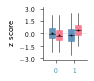

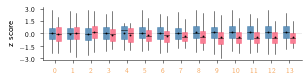

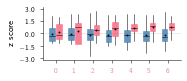

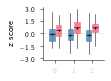

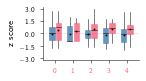

In [53]:
fig_height = 1.2
output = 'IOT+death'
group_names = ['dem', 'fc', 'ck', 'bm', 'scores']
idx_color = 0
for idx_group, y_group in enumerate(y_groups_sorted):
    labels_group = new_labels_groups_sorted[idx_group]
    n_variables_group = len(y_group)
    positions = np.arange(n_variables_group)
    ratio = 5./n_variables_group
    fig_width = 1. + fig_height/ratio
    if n_variables_group<7:
        fig_width = 0.9 + fig_height/ratio
        
    CF.SetPlotParams(height=fig_height, width=fig_width,
                            fontsize=fontsize, ylabelsize=ylabelsize,
                            xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, 
                            lines_w=lines_w, legendmarker=True)

    Data = DataInpatients[y_group+[output]].copy()

    plt.axhline(0, lw=0.5, color=grey_2)

    # Make plot
    for i, key in enumerate(Data):
        if key!=output:

            Data_xy = Data[[key,output]].copy().dropna()
            y = Data_xy[output].values
            x = Data_xy[key].values
            x_norm = pt.fit_transform(ss.fit_transform(x.reshape(-1, 1))).reshape(-1,)
            x_norm_0 = x_norm[y==0]
            x_norm_1 = x_norm[y==1]

            bp = plt.boxplot(x=x_norm_0, positions=[i-0.18],
                        widths=widths, showfliers=showfliers, showcaps=showcaps, 
                           showmeans=False, meanprops=meanprops,patch_artist=True)
            for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
            for box in bp['boxes']:
                box.set(color=color_0, linewidth=0.5, alpha=1.)
                box.set(facecolor=color_0, alpha=0.65)

            bp = plt.boxplot(x=x_norm_1, positions=[i+0.18],
                        widths=widths, showfliers=showfliers, showcaps=showcaps, 
                           showmeans=True, meanprops=meanprops,patch_artist=True)
            for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
                plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
            for box in bp['boxes']:
                box.set(color=color_1, linewidth=0.5, alpha=0.65)
                box.set(facecolor=color_1, alpha=0.65)

    #plt.xticks(positions, labels_group, rotation=90)
    plt.xticks(positions, positions)
    plt.yticks([-3, -1.5, 0, 1.5, 3])
    plt.ylim([-3.2, 3.2])
    plt.ylabel('z score')

    ax = plt.gca()
    for xtick, color in zip(ax.get_xticklabels(), colors[idx_color:idx_color+n_variables_group]):
        xtick.set_color(color)
    idx_color += n_variables_group
    group_name = group_names[idx_group]
    name_feat_vs_outcome = group_name + 'VSoutcome'
    saving_str = path_figures + name_feat_vs_outcome + '.pdf'
    #plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,

    plt.show()

### Sex hist

63 75


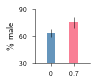

In [98]:
fig_height = 1.25
key = 'sex'
output = 'IOT+death'
Data = DataInpatients.copy()
Data_xy = Data[[key,output]].copy().dropna()
y = Data_xy[output].values
x = Data_xy[key].values
frac_male_0 = sum((x==0) & (y==0))/sum(y==0)
ci0_low, ci0_up = proportion_confint(sum((x==0) & (y==0)), sum(y==0), alpha=0.05, method='binom_test')
frac_male_1 = sum((x==0) & (y==1))/sum(y==1)
ci1_low, ci1_up = proportion_confint(sum((x==0) & (y==1)), sum(y==1), alpha=0.05, method='binom_test')
perc_male_0 = round(frac_male_0*100)
yerr_perc_male_0 = np.array([(frac_male_0 - ci0_low)*100, (ci0_up - frac_male_0)*100]).reshape(-1,1)
perc_male_1 = round(frac_male_1*100)
yerr_perc_male_1 = np.array([(frac_male_1 - ci1_low)*100, (ci1_up - frac_male_1)*100]).reshape(-1,1)
print(perc_male_0, perc_male_1)

fig, ax = plt.subplots()

n_bins = 2
positions = np.arange(n_bins)
ratio = 6./n_bins
fig_width = 1. + fig_height/ratio

CF.SetPlotParams(height=fig_height, width=fig_width,
                        fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, 
                        lines_w=lines_w, legendmarker=True)

lines_w = 0.5
capsize = 0
widths = 0.25
ax.bar(0, perc_male_0, yerr=yerr_perc_male_0, color=color_0, alpha=0.65, width=widths, lw=lines_w, capsize=capsize)
ax.bar(0.7, perc_male_1, yerr=yerr_perc_male_1, color=color_1, alpha=0.65, width=widths, lw=lines_w, capsize=capsize)

plt.yticks([30, 60, 90])
plt.ylim([30, 90])
plt.xticks([0, 0.7], [0, 0.7], )
plt.xlim([-0.5, 1.2])

plt.ylabel('\% male')

saving_str = path_figures + 'sexVSoutput' + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

# Covariates vs WHO

In [62]:
ms = 7.
capsize = 0.
lw = 1.2

x_col = 'WHO'

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5
widths = 0.3
showfliers = False
showcaps = False

magnification = 0.68
meanprops = {'color':'black', 'markerfacecolor':'black', 'markeredgecolor':'black', 'marker':'.', 'ms':1.7}

positions = [0., 1.75*widths, 3.5*widths, 5.25*widths, 7*widths]

### Immune cells

In [63]:
color = color_immunecells
colors = [color_control] + [color]*4
alphas = [0.8, 0.5, 0.5, 0.5, 0.5]
x_labels = ['control', 'WHO $\\le$ 1', 'WHO $=$ 2', 'WHO $=$ 3', 'WHO $\\ge$ 4']
x_labels = ['C', '1', '2', '3', '4']

#### Set 4

In [66]:
name_feat_vs_WHO = 'immunecells4' + 'VSwho'
y_variables = ['NK/uL', 'B CD19/uL', 'T CD3/uL', 'T CD4/uL', '% T CD4 HLADR POS', 'T CD8/uL', '% T CD8 HLADR POS']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

strat_variable = 'WHO'
output = 'IOT+death'

# data
Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()

# change 'WHO' values
Data.loc[Data[x_col]==0, x_col] = 1
Data.loc[Data[x_col]==5, x_col] = 4
Data_c[x_col] = 0

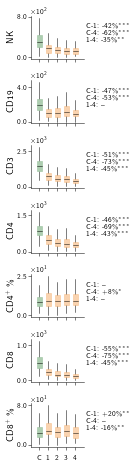

In [68]:
ratio = len(y_variables)/2.1

CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):

    input_variable = var


    # data_to_plot
    data_to_boxplot = []
    mask = Data_c[x_col].values==0
    v = Data_c.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data_complete[x_col].values>0
    v = Data_complete.loc[mask, input_variable].dropna().values
    #data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==1
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==2
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==3
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==4
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)

    idx = 0
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 1
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 2
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 3
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 4
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

        
    my_string = ''
    for k in range(5):
        for j in range(k+1, 5):
            a = data_to_boxplot[k]
            b = data_to_boxplot[j]
            st_val, p_val = st.mannwhitneyu(a, b) #st.ttest_ind(a, b, equal_var=False, nan_policy='omit') #
            perc_change = 100*(np.median(b)-np.median(a))/np.median(a)

            if k==0 and j==1: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = 'C-1: -'
                    else:
                        s = 'C-1: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = 'C-1: --'
                my_string = my_string+s+'\n'

            if k==0 and j==4: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = 'C-4: -'
                    else:
                        s = 'C-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = 'C-4: --'                
                my_string = my_string+s+'\n'

            if k==1 and j==2: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-2: -'
                    else:
                        s = '1-2: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-2: --'                
                #my_string = my_string+s+'\n'

            if k==1 and j==4: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-4: -'
                    else:
                        s = '1-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-4: --'                
                my_string = my_string+s+'\n'

            if k==3 and j==4: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '3-4: -'
                    else:
                        s = '3-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '3-4: --'                
                #my_string = my_string+s+'\n'

    ax[i].text(1.05, 0.5, my_string,
               horizontalalignment='left',
               verticalalignment='center',
               rotation='horizontal',
               transform=ax[i].transAxes,
               fontsize=ylabelsize)


    yScalarFormatter = cc.ScalarFormatterClass(m=1)
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    
    x_ticks_pos = np.array(positions)
    ax[i].set_xticks(x_ticks_pos)
    ax[i].set_xticklabels(x_labels)
    ax[i].set_xlabel(None)
    ax[i].tick_params(axis='y', pad=1.5)
    ax[i].yaxis.labelpad = 1.5
    new_ylabel = CF.change_names_2([input_variable], units=False)
    ax[i].set_ylabel(new_labels[i])
    ax[i].grid(False)

plt.xticks(x_ticks_pos, x_labels)


name_1 = input_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
name_2 = strat_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
saving_str = path_figures + name_feat_vs_WHO + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,

plt.show()

#### Set 5

In [69]:
name_feat_vs_WHO = 'immunecells5' + 'VSwho'
y_variables = ['WBC/uL', 'Mono/uL', 'MONO DR IFI', 'Mono DR %', 'Linfo/uL', 'LRTE/uL', 'LRTE % dei CD4']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()

# change 'WHO' values
Data.loc[Data[x_col]==0, x_col] = 1
Data.loc[Data[x_col]==5, x_col] = 4
Data_c[x_col] = 0

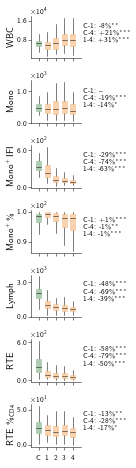

In [70]:
ratio = len(y_variables)/2.1

CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):

    input_variable = var


    # data_to_plot
    data_to_boxplot = []
    mask = Data_c[x_col].values==0
    v = Data_c.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data_complete[x_col].values>0
    v = Data_complete.loc[mask, input_variable].dropna().values
    #data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==1
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==2
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==3
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==4
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)

    idx = 0
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 1
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 2
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 3
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 4
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    my_string = ''
    for k in range(5):
        for j in range(k+1, 5):
            a = data_to_boxplot[k]
            b = data_to_boxplot[j]
            st_val, p_val = st.mannwhitneyu(a, b) #st.ttest_ind(a, b, equal_var=False, nan_policy='omit') #
            perc_change = 100*(np.median(b)-np.median(a))/np.median(a)

            if k==0 and j==1: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = 'C-1: -'
                    else:
                        s = 'C-1: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = 'C-1: --'
                my_string = my_string+s+'\n'

            if k==0 and j==4: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = 'C-4: -'
                    else:
                        s = 'C-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = 'C-4: --'                
                my_string = my_string+s+'\n'

            if k==1 and j==2: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-2: -'
                    else:
                        s = '1-2: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-2: --'                
                #my_string = my_string+s+'\n'

            if k==1 and j==4: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-4: -'
                    else:
                        s = '1-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-4: --'                
                my_string = my_string+s+'\n'

            if k==3 and j==4: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '3-4: -'
                    else:
                        s = '3-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '3-4: --'                
                #my_string = my_string+s+'\n'

    ax[i].text(1.05, 0.5, my_string,
               horizontalalignment='left',
               verticalalignment='center',
               rotation='horizontal',
               transform=ax[i].transAxes,
               fontsize=ylabelsize)


    yScalarFormatter = cc.ScalarFormatterClass(m=1)
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    
    x_ticks_pos = np.array(positions)
    ax[i].set_xticks(x_ticks_pos)
    ax[i].set_xticklabels(x_labels)
    ax[i].set_xlabel(None)
    ax[i].tick_params(axis='y', pad=1.5)
    ax[i].yaxis.labelpad = 1.5
    new_ylabel = CF.change_names_2([input_variable], units=False)
    ax[i].set_ylabel(new_labels[i])
    ax[i].grid(False)

plt.xticks(x_ticks_pos, x_labels)


name_1 = input_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
name_2 = strat_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
saving_str = path_figures + name_feat_vs_WHO + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,

plt.show()

### Cytokines

In [73]:
color = color_cytokines
colors = [color]*4
alphas = [0.5, 0.5, 0.5, 0.5]
x_labels = ['1', '2', '3', '4']

In [74]:
name_feat_vs_WHO = 'cytokines' + 'VSwho'
y_variables = ['IL10', 'IL6', 'IL8', 'IL1B', 'IL2R', 'IP10', 'IFNGC']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()

# change 'WHO' values
Data.loc[Data[x_col]==0, x_col] = 1
Data.loc[Data[x_col]==5, x_col] = 4

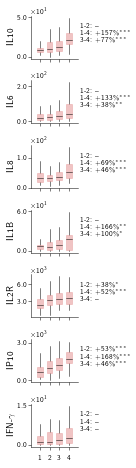

In [75]:
ratio = len(y_variables)/2.1

CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):

    input_variable = var


    # data_to_plot
    data_to_boxplot = []
    mask = Data[x_col].values>0
    v = Data.loc[mask, input_variable].dropna().values
    #data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==1
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==2
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==3
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==4
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)

    idx = 0
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 1
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 2
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 3
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    my_string = ''
    for k in range(4):
        for j in range(k+1, 4):
            a = data_to_boxplot[k]
            b = data_to_boxplot[j]
            st_val, p_val = st.mannwhitneyu(a, b) #st.ttest_ind(a, b, equal_var=False, nan_policy='omit') #
            perc_change = 100*(np.median(b)-np.median(a))/np.median(a)

            if k==0 and j==1: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-2: -'
                    else:
                        s = '1-2: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-2: --'
                my_string = my_string+s+'\n'

            if k==0 and j==3: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-4: -'
                    else:
                        s = '1-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-4: --'                
                my_string = my_string+s+'\n'

            if k==2 and j==3: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '3-4: -'
                    else:
                        s = '3-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '3-4: --'                
                my_string = my_string+s+'\n'

    ax[i].text(1.05, 0.5, my_string,
               horizontalalignment='left',
               verticalalignment='center',
               rotation='horizontal',
               transform=ax[i].transAxes,
               fontsize=ylabelsize)


    yScalarFormatter = cc.ScalarFormatterClass(m=1)
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    
    x_ticks_pos = np.array(positions[:-1])
    ax[i].set_xticks(x_ticks_pos)
    ax[i].set_xticklabels(x_labels)
    ax[i].set_xlabel(None)
    ax[i].tick_params(axis='y', pad=1.5)
    ax[i].yaxis.labelpad = 1.5
    new_ylabel = CF.change_names_2([input_variable], units=False)
    ax[i].set_ylabel(new_labels[i])
    ax[i].grid(False)

plt.xticks(x_ticks_pos, x_labels)


name_1 = input_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
#name_2 = strat_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
saving_str = path_figures + name_feat_vs_WHO + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,

plt.show()

### Biomarkers

In [76]:
color = color_bloodtests2
colors = [color]*4
alphas = [0.5, 0.5, 0.5, 0.5]
x_labels = ['control', 'WHO $\\le$ 1', 'WHO $=$ 2', 'WHO $=$ 3', 'WHO $\\ge$ 4']
x_labels = ['1', '2', '3', '4']

In [77]:
name_feat_vs_WHO = 'biomarkers' + 'VSwho'
y_variables = ['LDH', 'PROADM', 'PCR']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()

# change 'WHO' values
Data.loc[Data[x_col]==0, x_col] = 1
Data.loc[Data[x_col]==5, x_col] = 4

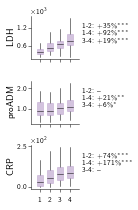

In [78]:
ratio = len(y_variables)/2.

mag_corr = 1.01
CF.SetPlotParams(magnification=mag_corr*magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):

    input_variable = var


    # data_to_plot
    data_to_boxplot = []
    mask = Data_complete[x_col].values>0
    v = Data_complete.loc[mask, input_variable].dropna().values
    #data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==1
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==2
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==3
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==4
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)

    idx = 0
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 1
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 2
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 3
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])


    my_string = ''
    for k in range(4):
        for j in range(k+1, 4):
            a = data_to_boxplot[k]
            b = data_to_boxplot[j]
            st_val, p_val = st.mannwhitneyu(a, b) #st.ttest_ind(a, b, equal_var=False, nan_policy='omit') 
            perc_change = 100*(np.median(b)-np.median(a))/np.median(a)

            if k==0 and j==1: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-2: -'
                    else:
                        s = '1-2: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-2: --'
                my_string = my_string+s+'\n'

            if k==0 and j==3: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-4: -'
                    else:
                        s = '1-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-4: --'                
                my_string = my_string+s+'\n'

            if k==2 and j==3: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '3-4: -'
                    else:
                        s = '3-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '3-4: --'                
                my_string = my_string+s+'\n'

    ax[i].text(1.05, 0.5, my_string,
               horizontalalignment='left',
               verticalalignment='center',
               rotation='horizontal',
               transform=ax[i].transAxes,
               fontsize=ylabelsize)


    yScalarFormatter = cc.ScalarFormatterClass(m=1)
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    
    x_ticks_pos = np.array(positions[:-1])
    ax[i].set_xticks(x_ticks_pos)
    ax[i].set_xticklabels(x_labels)
    ax[i].set_xlabel(None)
    ax[i].tick_params(axis='y', pad=1.5)
    ax[i].yaxis.labelpad = 1.5
    new_ylabel = CF.change_names_2([input_variable], units=False)
    ax[i].set_ylabel(new_labels[i])
    ax[i].grid(False)

plt.xticks(x_ticks_pos, x_labels)


name_1 = input_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
name_2 = strat_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
saving_str = path_figures + name_feat_vs_WHO + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,

plt.show()

### Demographics

In [81]:
color = color_0_light
colors = [color]*4
alphas = [0.5, 0.5, 0.5, 0.5]
x_labels = ['1', '2', '3', '4']

In [82]:
name_feat_vs_WHO = 'demographics' + 'VSwho'
y_variables = ['age', 'delta_onset']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()

# change 'WHO' values
Data.loc[Data[x_col]==0, x_col] = 1
Data.loc[Data[x_col]==5, x_col] = 4

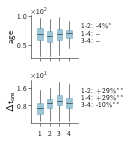

In [87]:
ratio = len(y_variables)/1.8

mag_corr = .95
CF.SetPlotParams(magnification=mag_corr*magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):

    input_variable = var


    # data_to_plot
    data_to_boxplot = []
    mask = Data_complete[x_col].values>0
    v = Data_complete.loc[mask, input_variable].dropna().values
    #data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==1
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==2
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==3
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = Data[x_col].values==4
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)

    idx = 0
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 1
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 2
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])

    idx = 3
    bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                widths=widths, showfliers=showfliers, showcaps=showcaps, 
                       showmeans=False, meanprops=meanprops,patch_artist=True)
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
    for box in bp['boxes']:
        box.set(color=colors[idx], linewidth=0.7, alpha=1.)
        box.set(facecolor = colors[idx], alpha=alphas[idx])


    my_string = ''
    for k in range(4):
        for j in range(k+1, 4):
            a = data_to_boxplot[k]
            b = data_to_boxplot[j]
            st_val, p_val = st.mannwhitneyu(a, b) #st.ttest_ind(a, b, equal_var=False, nan_policy='omit') 
            perc_change = 100*(np.median(b)-np.median(a))/np.median(a)

            if k==0 and j==1: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-2: -'
                    else:
                        s = '1-2: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-2: --'
                my_string = my_string+s+'\n'

            if k==0 and j==3: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '1-4: -'
                    else:
                        s = '1-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '1-4: --'                
                my_string = my_string+s+'\n'

            if k==2 and j==3: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = '3-4: -'
                    else:
                        s = '3-4: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = '3-4: --'                
                my_string = my_string+s+'\n'

    ax[i].text(1.05, 0.5, my_string,
               horizontalalignment='left',
               verticalalignment='center',
               rotation='horizontal',
               transform=ax[i].transAxes,
               fontsize=ylabelsize)


    yScalarFormatter = cc.ScalarFormatterClass(m=1)
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    
    x_ticks_pos = np.array(positions[:-1])
    ax[i].set_xticks(x_ticks_pos)
    ax[i].set_xticklabels(x_labels)
    ax[i].set_xlabel(None)
    ax[i].tick_params(axis='y', pad=1.5)
    ax[i].yaxis.labelpad = 1.5
    new_ylabel = CF.change_names_2([input_variable], units=False)
    ax[i].set_ylabel(new_labels[i])
    ax[i].grid(False)

plt.xticks(x_ticks_pos, x_labels)


name_1 = input_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
name_2 = strat_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
saving_str = path_figures + name_feat_vs_WHO + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,

plt.show()

## Output vs WHO

In [ ]:
ms = 6.
capsize = 0.
lw = 1.2

time_col = 'WHO'
set_yticks = True
color_ref = 'black'

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5

alpha_shade = 0.2
half_window = 0.5
min_time = -1 - half_window
max_time = 5 + half_window
x_max_display = 5
x_max_lim = x_max_display + 1

magnification = 0.7

color = color_1

/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  

hospitalization_length
1 2 1.029294478527607 0.13148340126412142
1 4 13.845731707317075 3.0911542304038085e-20
3 4 8.71412013706914 1.3219433465463515e-09

infectious_complications
Change: 1-2 - 0.01
Exact test: 1.000
Change: 1-4 - 0.16
Exact test: 0.013
Change: 3-4 - 0.15
Exact test: 0.000

IOT
Change: 1-2 - 0.00
Exact test: 1.000
Change: 1-4 - 0.47
Exact test: 0.000
Change: 3-4 - 0.40
Exact test: 0.000

merged_death
Change: 1-2 - 0.00
Exact test: 1.000
Change: 1-4 - 0.40
Exact test: 0.000
Change: 3-4 - 0.28


/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.ty

Exact test: 0.000

IOT+death
Change: 1-2 - 0.00
Exact test: 1.000
Change: 1-4 - 0.58
Exact test: 0.000
Change: 3-4 - 0.43
Exact test: 0.000



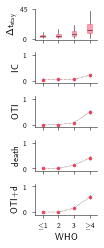

In [ ]:
name_outcome_vs_time = 'outcome' + 'VSWHO'
y_variables = ['hospitalization_length', 'infectious_complications', 'IOT', 'merged_death', 'IOT+death']
new_labels = ['$\mathrm{\Delta t_{stay}}$', 'IC', 'OTI', 'death', 'OTI+d']
n_variables = len(y_variables)

# data
Data = Data_V2.copy()

# drop na and remove outliers
Data = Data[y_variables+[time_col]]
ss = StandardScaler()
pt = PowerTransformer()
Data_norm = pt.fit_transform(ss.fit_transform(Data[['hospitalization_length']].values))
mask = np.abs(Data_norm.ravel()) > zscore_th
Data.loc[mask, 'hospitalization_length'] = np.nan
Data.loc[Data['WHO']==0, 'WHO'] = 1
Data.loc[Data['WHO']==5, 'WHO'] = 4

ratio = len(y_variables)/3.

#fig_width = 2.9 * magnification # width in inches
#fig_height = fig_width*ratio  # height in inches

width_correction = .75 #1
height_correction = 1.39 #1.125
alpha_whisk = 1.

CF.SetPlotParams(magnification=width_correction*magnification, ratio=height_correction*ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    x, y, y_err = CF.moving_average(Data, var, time_col, half_window=half_window, min_time=min_time, max_time=max_time)
    
    if var=='hospitalization_length':
        strat_variable='WHO'
        bar_width = 0.4
        data_to_boxplot = []
        #
        mask = Data[strat_variable].values==1
        v = Data.loc[mask, var].dropna().values
        data_to_boxplot.append(v)
        #
        mask = Data[strat_variable].values==2
        v = Data.loc[mask, var].dropna().values
        data_to_boxplot.append(v)
        #
        mask = Data[strat_variable].values==3
        v = Data.loc[mask, var].dropna().values
        data_to_boxplot.append(v)
        #
        mask = Data[strat_variable].values==4
        v = Data.loc[mask, var].dropna().values
        data_to_boxplot.append(v)
        
        idx = 0
        positions = [1, 2, 3, 4]
        alphas = [0.5]*4
        colors = [color_1]*4
        bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                    widths=widths, showfliers=showfliers, showcaps=showcaps, patch_artist=True)
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
        plt.setp(bp['whiskers'], color='black', lw=0.5, alpha=alpha_whisk)
        for box in bp['boxes']:
            box.set(color=colors[idx], linewidth=0.7, alpha=1.)
            box.set(facecolor = colors[idx], alpha=alphas[idx])

        idx = 1
        bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                    widths=widths, showfliers=showfliers, showcaps=showcaps, patch_artist=True)
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
        plt.setp(bp['whiskers'], color='black', lw=0.5, alpha=alpha_whisk)
        for box in bp['boxes']:
            box.set(color=colors[idx], linewidth=0.7, alpha=1.)
            box.set(facecolor = colors[idx], alpha=alphas[idx])

        idx = 2
        bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                    widths=widths, showfliers=showfliers, showcaps=showcaps, patch_artist=True)
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black', lw=0.5, alpha=1.)      
        plt.setp(bp['whiskers'], color='black', lw=0.5, alpha=alpha_whisk)
        for box in bp['boxes']:
            box.set(color=colors[idx], linewidth=0.7, alpha=1.)
            box.set(facecolor = colors[idx], alpha=alphas[idx])

        idx = 3
        bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                    widths=widths, showfliers=showfliers, showcaps=showcaps, patch_artist=True)
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black', lw=0.5, alpha=1.)
        plt.setp(bp['whiskers'], color='black', lw=0.5, alpha=alpha_whisk)
        for box in bp['boxes']:
            box.set(color=colors[idx], linewidth=0.7, alpha=1.)
            box.set(facecolor = colors[idx], alpha=alphas[idx])
        
        ax[i].set_yticks([0, 45])
        ax[i].set_xticks([1, 2, 3, 4])
        ax[i].set_ylabel(new_labels[i])
        ax[i].set_xlabel(None)
        
        # compute p values and changes
        print(var)
        for k in range(4):
            for j in range(k+1, 4):
                a = data_to_boxplot[k]
                b = data_to_boxplot[j]
                st_val, p_val = st.ttest_ind(a, b, equal_var=False, nan_policy='omit') 
                perc_change = 100*(np.mean(b)-np.mean(a))/np.mean(a)
                change = np.mean(b)-np.mean(a)

                if (k==0 and j==1) | (k==0 and j==3) | (k==2 and j==3): 
                    print(k+1, j+1, change, p_val)
        print('')
        
    else:
        print(var)
        strat_variable='WHO'
        #
        mask = Data[strat_variable].values==1
        v1 = Data.loc[mask, var].dropna().values
        col1 = [sum(v1==0), sum(v1==1)]
        #
        mask = Data[strat_variable].values==2
        v2 = Data.loc[mask, var].dropna().values
        col2 = [sum(v2==0), sum(v2==1)]
        #
        mask = Data[strat_variable].values==3
        v3 = Data.loc[mask, var].dropna().values
        col3 = [sum(v3==0), sum(v3==1)]
        #
        mask = Data[strat_variable].values==4
        v4 = Data.loc[mask, var].dropna().values
        col4 = [sum(v4==0), sum(v4==1)]
        #
        table12 = np.array([col1, col2]).T
        perc_change12 = 100*(np.mean(v2)-np.mean(v1))/np.mean(v1)
        change12 = np.mean(v2)-np.mean(v1)
        table14 = np.array([col1, col4]).T
        perc_change14 = 100*(np.mean(v4)-np.mean(v1))/np.mean(v1)
        change14 = np.mean(v4)-np.mean(v1)
        table34 = np.array([col3, col4]).T
        perc_change34 = 100*(np.mean(v4)-np.mean(v3))/np.mean(v3)
        change34 = np.mean(v4)-np.mean(v3)
        print('Change: 1-2 - %.2f' % change12)
        print('Exact test: %.3f' % st.fisher_exact(table12)[1])
        print('Change: 1-4 - %.2f' % change14)
        print('Exact test: %.3f' % st.fisher_exact(table14)[1])
        print('Change: 3-4 - %.2f' % change34)
        print('Exact test: %.3f' % st.fisher_exact(table34)[1])
        print('')
        
        ax[i].plot(x, y, ls=':', lw=0.5, color='black')
        ax[i].errorbar(x, y, y_err, ls='', marker='.', ms=5, capsize=0, lw=0.5, color=color, ecolor='black')
        ax[i].set_xticks([1, 2, 3, 4])
        #ax[i].set_xlim([0, x_max_lim])

        ax[i].grid(False)
        #yScalarFormatter = cc.ScalarFormatterClass(useMathText=True)
        #yScalarFormatter.set_powerlimits((0,0))
        #ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
        #ax[i].yaxis.set_major_formatter(yScalarFormatter)

        ax[i].set_ylabel(new_labels[i])
        if i==0:
            ax[i].set_yticks([10, 25])
        elif i>0:
            ax[i].set_ylim([-0.1, 1.1])
    
    '''
    if i==0:
        ax[i].set_yticks([0.1, 0.3])
    elif i==1:
        ax[i].set_yticks([0.1, 0.3])
    elif i==2:
        ax[i].set_yticks([0.1, 0.4])
    elif i==3:
        ax[i].set_yticks([0.1, 0.4])
    elif i==4:
        ax[i].set_yticks([0.1, 0.3])
        ax[i].set_ylim([y_min, 0.3])
    elif i==5:
        ax[i].set_yticks([5, 15])
    '''
    
    #ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
        
ax[i].set_xticklabels(['$\le$1', '2', '3', '$\ge$4'])
ax[i].set_xlabel('WHO')

saving_str = path_figures + name_outcome_vs_time + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

# Boxplots: control FC vs age

In [143]:
ms = 7.
capsize = 0.
lw = 1.2

x_col = 'age_strat'

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5
widths = 0.3
showfliers = False
showcaps = False
meanprops = {'color':'black', 'markerfacecolor':'black', 'markeredgecolor':'black', 'marker':'.', 'ms':1.7}

magnification = 0.68

positions = [0., 1.2*widths, 3.5*widths, 4.7*widths]

In [144]:
color = color_immunecells
colors = [color_control, color, color_control, color]
alphas = [0.8, 0.5, 0.8, 0.5]
x_labels = ['L', 'H']
x_ticks_pos = [0.6*widths, 3.8*widths]

In [145]:
age_th1 = 40
age_th2 = 60
age_th3 = 80

# data
Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()

# Add age_strat column
Data['age_strat'] = np.nan
age = Data['age'].values
mask1 = (age>=age_th1) & (age<age_th2)
Data.loc[mask1,'age_strat'] = 1
mask2 = (age>=age_th2) & (age<age_th3)
Data.loc[mask2,'age_strat'] = 0
Data_c['age_strat'] = np.nan
age = Data_c['age'].values
mask1 = (age>=age_th1) & (age<age_th2)
Data_c.loc[mask1,'age_strat'] = 1
mask2 = (age>=age_th2) & (age<age_th3)
Data_c.loc[mask2,'age_strat'] = 0

#### Set 4

In [157]:
name_feat_vs_popage = 'immunecells4' + 'VSpopulation&age'
y_variables = ['NK/uL', 'B CD19/uL', 'T CD3/uL', 'T CD4/uL', '% T CD4 HLADR POS', 'T CD8/uL', '% T CD8 HLADR POS']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

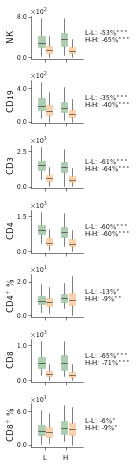

In [160]:
ratio = len(y_variables)/2.1

CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):

    input_variable = var


    # data_to_plot
    data_to_boxplot = []
    mask = (Data_c[x_col].values==1)
    v = Data_c.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = (Data[x_col].values==1)
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = (Data_c[x_col].values==0)
    v = Data_c.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = (Data[x_col].values==0)
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)

    for idx in range(len(data_to_boxplot)):
        bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                    widths=widths, showfliers=showfliers, showcaps=showcaps, 
                        showmeans=False, meanprops=meanprops, patch_artist=True)
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black', lw=0.5, alpha=1.)   
        for box in bp['boxes']:
            box.set(color=colors[idx], linewidth=0.7, alpha=1.)
            box.set(facecolor = colors[idx], alpha=alphas[idx])

        
    my_string = ''
    for k in range(4):
        for j in range(k+1, 4):
            a = data_to_boxplot[k]
            b = data_to_boxplot[j]
            st_val, p_val = st.mannwhitneyu(a, b) #st.ttest_ind(a, b, equal_var=False, nan_policy='omit') 
            perc_change = 100*(np.median(b)-np.median(a))/np.median(a)

            if k==0 and j==1: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = 'L-L: -'
                    else:
                        s = 'L-L: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = 'L-L: --'
                my_string = my_string+s+'\n'

            if k==2 and j==3: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = 'H-H: -'
                    else:
                        s = 'H-H: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = 'H-H: --'                
                my_string = my_string+s

    ax[i].text(1.05, 0.5, my_string,
               horizontalalignment='left',
               verticalalignment='center',
               rotation='horizontal',
               transform=ax[i].transAxes,
               fontsize=ylabelsize)


    yScalarFormatter = cc.ScalarFormatterClass(m=1)
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    
    ax[i].set_xticks(x_ticks_pos)
    ax[i].set_xticklabels(x_labels)
    ax[i].set_xlabel(None)
    ax[i].tick_params(axis='y', pad=1.5)
    ax[i].yaxis.labelpad = 1.5
    new_ylabel = CF.change_names_2([input_variable], units=False)
    ax[i].set_ylabel(new_labels[i])
    ax[i].grid(False)

plt.xticks(x_ticks_pos, x_labels)

name_1 = input_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
name_2 = strat_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
saving_str = path_figures + name_feat_vs_popage + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

#### Set 5

In [152]:
name_feat_vs_popage = 'immunecells5' + 'VSpopulation&age'
y_variables = ['WBC/uL', 'Mono/uL', 'MONO DR IFI', 'Mono DR %', 'Linfo/uL', 'LRTE/uL', 'LRTE % dei CD4']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

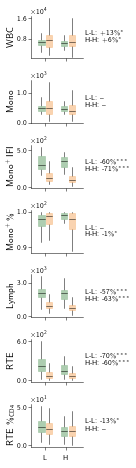

In [153]:
ratio = len(y_variables)/2.1

CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):

    input_variable = var


    # data_to_plot
    data_to_boxplot = []
    mask = (Data_c[x_col].values==1)
    v = Data_c.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = (Data[x_col].values==1)
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = (Data_c[x_col].values==0)
    v = Data_c.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)
    #
    mask = (Data[x_col].values==0)
    v = Data.loc[mask, input_variable].dropna().values
    data_to_boxplot.append(v)

    for idx in range(len(data_to_boxplot)):
        bp = ax[i].boxplot(x=data_to_boxplot[idx], positions=[positions[idx]],
                    widths=widths, showfliers=showfliers, showcaps=showcaps, 
                        showmeans=False, meanprops=meanprops, patch_artist=True)
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color='black', lw=0.5, alpha=1.)   
        for box in bp['boxes']:
            box.set(color=colors[idx], linewidth=0.7, alpha=1.)
            box.set(facecolor = colors[idx], alpha=alphas[idx])

        
    my_string = ''
    for k in range(4):
        for j in range(k+1, 4):
            a = data_to_boxplot[k]
            b = data_to_boxplot[j]
            st_val, p_val = st.mannwhitneyu(a, b) #st.ttest_ind(a, b, equal_var=False, nan_policy='omit') 
            perc_change = 100*(np.median(b)-np.median(a))/np.median(a)

            if k==0 and j==1: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = 'L-L: -'
                    else:
                        s = 'L-L: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = 'L-L: --'
                my_string = my_string+s+'\n'

            if k==2 and j==3: 
                #print(i, j, st_val, p_val, np.mean(a)-np.mean(b))
                # p values
                if p_val<0.05:
                    p_val_not = '$^{*\,}$'                
                    if p_val<0.01:
                        p_val_not = '$^{**\,}$'
                    if p_val<0.001:
                        p_val_not = '$^{***}$'
                    if perc_change<0:
                        s = 'H-H: -'
                    else:
                        s = 'H-H: +'
                    s = s + '$%.0f$' % (abs(perc_change))
                    s = s + '\%' + p_val_not
                else:
                    s = 'H-H: --'                
                my_string = my_string+s

    ax[i].text(1.05, 0.5, my_string,
               horizontalalignment='left',
               verticalalignment='center',
               rotation='horizontal',
               transform=ax[i].transAxes,
               fontsize=ylabelsize)

    yScalarFormatter = cc.ScalarFormatterClass(m=1)
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    
    ax[i].set_xticks(x_ticks_pos)
    ax[i].set_xticklabels(x_labels)
    ax[i].set_xlabel(None)
    ax[i].tick_params(axis='y', pad=1.5)
    ax[i].yaxis.labelpad = 1.5
    new_ylabel = CF.change_names_2([input_variable], units=False)
    ax[i].set_ylabel(new_labels[i])
    ax[i].grid(False)

plt.xticks(x_ticks_pos, x_labels)


name_1 = input_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
name_2 = strat_variable.replace('T ', '').replace('B ', '').replace('/', '').replace(' ', '').replace('\\', '')
saving_str = path_figures + name_feat_vs_popage + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,

plt.show()

# Covariates vs age

In [66]:
ms = 6.
capsize = 0.
lw = 1.2

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5

half_window = 15
min_age_val = 20
max_age_val = 110

max_time = max_age_val + half_window
x_min_display = 40
x_min_lim = x_min_display - 3
x_max_display = 100
x_max_lim = x_max_display + 3

x_min_display_c = 20
x_min_lim_c = x_min_display_c - 3
x_max_display_c = 80
x_max_lim_c = x_max_display_c + 3

time_col = 'age'
color_ref = green_pal1
alpha_ref = 0.5
alpha_shade_ref = 0.15
alpha_shade = 0.2

## FC outpatients

#### Set4

In [67]:
name_feat_vs_age = 'immunecells4' + 'VSage_HalfWindow#%d' % half_window
y_variables = ['NK/uL', 'B CD19/uL', 'T CD3/uL', 'T CD4/uL', '% T CD4 HLADR POS', 'T CD8/uL', '% T CD8 HLADR POS',]
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()

No handles with labels found to put in legend.


NK/uL
B CD19/uL


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


T CD3/uL
T CD4/uL
% T CD4 HLADR POS


No handles with labels found to put in legend.
No handles with labels found to put in legend.


T CD8/uL
% T CD8 HLADR POS


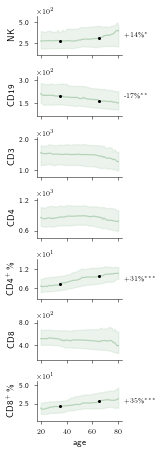

In [68]:
# Control only
magnification = 0.8
ratio = 5.5/2.
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x_c, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data_c, var, time_col, half_window=half_window, min_time=x_min_lim_c, max_time=x_max_lim_c)
    time_mask = (x_c>=x_min_display_c) & (x_c<=x_max_display_c)
    x_c = x_c[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x_c, y_mode, '-', lw=lw, color=color_ref, alpha=alpha_ref)
    ax[i].fill_between(x_c, y_q1, y_q3, lw=lw, color=color_ref, alpha=alpha_shade_ref)
        
    ax[i].set_xticks([20, 40, 60, 80])
    ax[i].set_xlim([x_min_lim_c, x_max_lim_c])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    # Compute difference and significance between ages
    timepoint_1 = 35
    Data_local = Data_c[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 65
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('age')

saving_str = path_figures + name_feat_vs_age + '_outpatients' + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

#### Set5

In [69]:
name_feat_vs_age = 'immunecells5' + 'VSage_HalfWindow#%d' % half_window
y_variables = ['WBC/uL', 'Mono/uL', 'MONO DR IFI', 'Mono DR %', 'Linfo/uL', 'LRTE/uL', 'LRTE % dei CD4']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


WBC/uL
Mono/uL
MONO DR IFI
Mono DR %


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Linfo/uL
LRTE/uL
LRTE % dei CD4


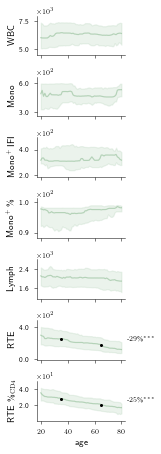

In [70]:
# Control only
magnification = 0.8
ratio = 5.5/2.
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x_c, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data_c, var, time_col, half_window=half_window, min_time=x_min_lim_c, max_time=x_max_lim_c)
    time_mask = (x_c>=x_min_display_c) & (x_c<=x_max_display_c)
    x_c = x_c[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x_c, y_mode, '-', lw=lw, color=color_ref, alpha=alpha_ref)
    ax[i].fill_between(x_c, y_q1, y_q3, lw=lw, color=color_ref, alpha=alpha_shade_ref)
        
    ax[i].set_xticks([20, 40, 60, 80])
    ax[i].set_xlim([x_min_lim_c, x_max_lim_c])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    # Compute difference and significance between ages
    timepoint_1 = 35
    Data_local = Data_c[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 65
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('age')

saving_str = path_figures + name_feat_vs_age + '_outpatients' + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## FC inpatients

In [127]:
color = color_immunecells

#### Set4

In [128]:
name_feat_vs_age = 'immunecells4' + 'VSage_HalfWindow#%d' % half_window
y_variables = ['NK/uL', 'B CD19/uL', 'T CD3/uL', 'T CD4/uL', '% T CD4 HLADR POS', 'T CD8/uL', '% T CD8 HLADR POS',]
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


NK/uL
B CD19/uL
T CD3/uL
T CD4/uL
% T CD4 HLADR POS


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


T CD8/uL
% T CD8 HLADR POS


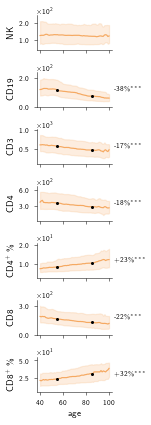

In [129]:
# Control only
magnification = 0.75
ratio = 5.5/2.
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data, var, time_col, half_window=half_window, min_time=x_min_lim, max_time=x_max_lim)
    time_mask = (x>=x_min_display) & (x<=x_max_display)
    x = x[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x, y_mode, '-', lw=lw, color=color)
    ax[i].fill_between(x, y_q1, y_q3, lw=lw, color=color, alpha=alpha_shade)
        
    ax[i].set_xticks([40, 60, 80, 100])
    ax[i].set_xlim([x_min_lim, x_max_lim])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    # Compute difference and significance between ages
    timepoint_1 = 55
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 85
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('age')

saving_str = path_figures + name_feat_vs_age + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

#### Set5

In [130]:
name_feat_vs_age = 'immunecells5' + 'VSage_HalfWindow#%d' % half_window
y_variables = ['WBC/uL', 'Mono/uL', 'MONO DR IFI', 'Mono DR %', 'Linfo/uL', 'LRTE/uL', 'LRTE % dei CD4']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


WBC/uL
Mono/uL
MONO DR IFI
Mono DR %


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Linfo/uL
LRTE/uL
LRTE % dei CD4


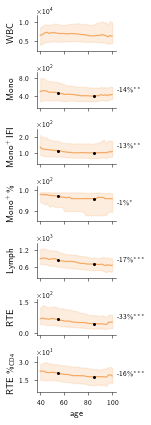

In [131]:
# Control only
magnification =  0.75
ratio = 5.5/2.
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data, var, time_col, half_window=half_window, min_time=x_min_lim, max_time=x_max_lim)
    time_mask = (x>=x_min_display) & (x<=x_max_display)
    x = x[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x, y_mode, '-', lw=lw, color=color)
    ax[i].fill_between(x, y_q1, y_q3, lw=lw, color=color, alpha=alpha_shade)
        
    ax[i].set_xticks([40, 60, 80, 100])
    ax[i].set_xlim([x_min_lim, x_max_lim])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    # Compute difference and significance between ages
    timepoint_1 = 55
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 85
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('age')

saving_str = path_figures + name_feat_vs_age + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## CK inpatients

In [133]:
color = color_cytokines

ref_values = {'IL1B': 0.16, 
              'IL8': 16.2,
              'IL2R': 1435,
              'IL10': 3.8,
              'IP10': 222,
              'IFNGC': 0.99,
              'IL6': 6.4}

In [134]:
name_feat_vs_age = 'cytokines3' + 'VSage_HalfWindow#%d' % half_window
y_variables = ['IL10', 'IL6', 'IL8', 'IL1B', 'IL2R', 'IP10', 'IFNGC']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


IL10
IL6
IL8
IL1B


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


IL2R
IP10
IFNGC


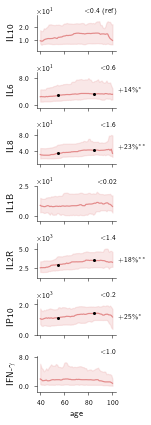

In [135]:
magnification =  0.75
ratio = 5.5/2.
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data, var, time_col, half_window=half_window, min_time=x_min_lim, max_time=x_max_lim)
    time_mask = (x>=x_min_display) & (x<=x_max_display)
    x = x[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x, y_mode, '-', lw=lw, color=color)
    ax[i].fill_between(x, y_q1, y_q3, lw=lw, color=color, alpha=alpha_shade)
        
    ax[i].set_xticks([40, 60, 80, 100])
    ax[i].set_xlim([x_min_lim, x_max_lim])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    #ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    if var in ref_values.keys():
        y_ref = ref_values[var]
        exp = int(np.log10(y_max))
        factor = y_ref/(10.**exp)
        val = 0
        d = 0
        while val==0:
            d += 1
            s_0 = '%%.%df' % d
            s = s_0 % factor
            val = float(s)
        ref_label = '$<$%s (ref)' % (s)
        if i>0:
            ref_label = '$<$%s' % (s)
        ax[i].text(1.0, 1.03, ref_label,
            horizontalalignment='right',
            verticalalignment='bottom',
            rotation='horizontal',
            transform=ax[i].transAxes,
            fontsize=ylabelsize)
    
    # Compute difference and significance between ages
    timepoint_1 = 55
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 85
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('age')

saving_str = path_figures + name_feat_vs_age + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## BM inpatients

In [136]:
color = color_bloodtests2

ref_values = {'LDH': 480, 
              'PROADM': 0.56,
              'PCR': 5}

In [137]:
name_feat_vs_age = 'biomarkers' + 'VSage_HalfWindow#%d' % half_window
y_variables = ['LDH', 'PROADM', 'PCR']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


LDH
PROADM
PCR


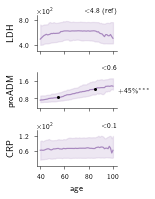

In [140]:
magnification = 0.77
ratio = 2.55/2.
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data, var, time_col, half_window=half_window, min_time=x_min_lim, max_time=x_max_lim)
    time_mask = (x>=x_min_display) & (x<=x_max_display)
    x = x[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x, y_mode, '-', lw=lw, color=color)
    ax[i].fill_between(x, y_q1, y_q3, lw=lw, color=color, alpha=alpha_shade)
        
    ax[i].set_xticks([40, 60, 80, 100])
    ax[i].set_xlim([x_min_lim, x_max_lim])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)

    if var in ref_values.keys():
        y_ref = ref_values[var]
        exp = int(np.log10(y_max))
        factor = y_ref/(10.**exp)
        val = 0
        d = 0
        while val==0:
            d += 1
            s_0 = '%%.%df' % d
            s = s_0 % factor
            val = float(s)
        ref_label = '$<$%s (ref)' % (s)
        if i>0:
            ref_label = '$<$%s' % (s)
        ax[i].text(1.0, 1.03, ref_label,
            horizontalalignment='right',
            verticalalignment='bottom',
            rotation='horizontal',
            transform=ax[i].transAxes,
            fontsize=ylabelsize)
    
    # Compute difference and significance between ages
    timepoint_1 = 55
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 85
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('age')

saving_str = path_figures + name_feat_vs_age + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

# Covariates vs $\Delta t_{\mathrm{ons}}$

In [191]:
ms = 6.
capsize = 0.
lw = 1.2

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5

half_window = 5
max_time = 20 + half_window
x_max_display = 20
x_max_lim = x_max_display + 1

time_col = 'delta_onset'
color_ref = green_pal1
alpha_ref = 0.5
alpha_shade_ref = 0.15
alpha_shade = 0.2

## FC inpatients

In [192]:
color = color_immunecells

#### Set4

In [193]:
name_feat_vs_time = 'immunecells4' + 'VSdonset_HalfWindow#%d' % half_window
y_variables = ['NK/uL', 'B CD19/uL', 'T CD3/uL', 'T CD4/uL', '% T CD4 HLADR POS', 'T CD8/uL', '% T CD8 HLADR POS',]
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()

No handles with labels found to put in legend.


NK/uL
B CD19/uL


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


T CD3/uL
T CD4/uL
% T CD4 HLADR POS
T CD8/uL
% T CD8 HLADR POS


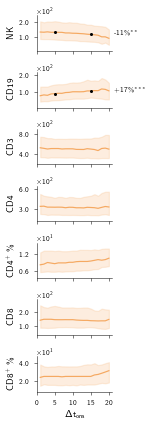

In [194]:
# Control only
magnification = 0.75
ratio = 5.5/2.
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data, var, time_col, half_window=half_window, max_time=x_max_lim)
    time_mask = (x>=0) & (x<=x_max_display)
    x = x[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x, y_mode, '-', lw=lw, color=color)
    ax[i].fill_between(x, y_q1, y_q3, lw=lw, color=color, alpha=alpha_shade)
        
    ax[i].set_xticks([0, 5, 10, 15, 20, 25])
    ax[i].set_xlim([0, x_max_lim])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    # Compute difference and significance between ages
    timepoint_1 = 5
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 15
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('$\mathrm{\Delta t_{ons}}$')

saving_str = path_figures + name_feat_vs_time + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

#### Set5

In [195]:
name_feat_vs_time = 'immunecells5' + 'VSdonset_HalfWindow#%d' % half_window
y_variables = ['WBC/uL', 'Mono/uL', 'MONO DR IFI', 'Mono DR %', 'Linfo/uL', 'LRTE/uL', 'LRTE % dei CD4']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()
Data_c = DataOutpatients.copy()

WBC/uL
Mono/uL
MONO DR IFI
Mono DR %
Linfo/uL
LRTE/uL
LRTE % dei CD4


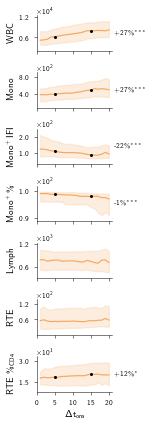

In [196]:
magnification = 0.75
ratio = 5.5/2.
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data, var, time_col, half_window=half_window, max_time=x_max_lim)
    time_mask = (x>=0) & (x<=x_max_display)
    x = x[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x, y_mode, '-', lw=lw, color=color)
    ax[i].fill_between(x, y_q1, y_q3, lw=lw, color=color, alpha=alpha_shade)
        
    ax[i].set_xticks([0, 5, 10, 15, 20, 25])
    ax[i].set_xlim([0, x_max_lim])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    #ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    # Compute difference and significance between ages
    timepoint_1 = 5
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 15
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('$\mathrm{\Delta t_{ons}}$')

saving_str = path_figures + name_feat_vs_time + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## CK inpatients

In [210]:
color = color_cytokines

ref_values = {'IL1B': 0.16, 
              'IL8': 16.2,
              'IL2R': 1435,
              'IL10': 3.8,
              'IP10': 222,
              'IFNGC': 0.99,
              'IL6': 6.4}

In [211]:
name_feat_vs_time = 'cytokines3' + 'VSdonset_HalfWindow#%d' % half_window
y_variables = ['IL10', 'IL6', 'IL8', 'IL1B', 'IL2R', 'IP10', 'IFNGC']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()

IL10
IL6
IL8
IL1B
IL2R
IP10
IFNGC


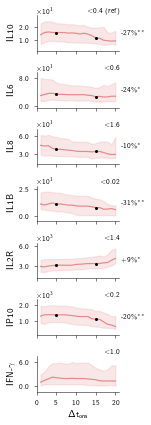

In [212]:
magnification = 0.75
ratio = 5.5/2.
CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data, var, time_col, half_window=half_window, max_time=x_max_lim)
    time_mask = (x>=0) & (x<=x_max_display)
    x = x[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x, y_mode, '-', lw=lw, color=color)
    ax[i].fill_between(x, y_q1, y_q3, lw=lw, color=color, alpha=alpha_shade)
        
    ax[i].set_xticks([0, 5, 10, 15, 20, 25])
    ax[i].set_xlim([0, x_max_lim])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    #ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    if var in ref_values.keys():
        y_ref = ref_values[var]
        exp = int(np.log10(y_max))
        factor = y_ref/(10.**exp)
        val = 0
        d = 0
        while val==0:
            d += 1
            s_0 = '%%.%df' % d
            s = s_0 % factor
            val = float(s)
        ref_label = '$<$%s (ref)' % (s)
        if i>0:
            ref_label = '$<$%s' % (s)
        ax[i].text(1.0, 1.03, ref_label,
            horizontalalignment='right',
            verticalalignment='bottom',
            rotation='horizontal',
            transform=ax[i].transAxes,
            fontsize=ylabelsize)
        
    # Compute difference and significance between ages
    timepoint_1 = 5
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 15
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('$\mathrm{\Delta t_{ons}}$')

saving_str = path_figures + name_feat_vs_time + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

## BM inpatients

In [213]:
color = color_bloodtests2

ref_values = {'LDH': 480, 
              'PROADM': 0.56,
              'PCR': 5}

In [214]:
name_feat_vs_time = 'biomarkers' + 'VSdonset_HalfWindow#%d' % half_window
y_variables = ['LDH', 'PROADM', 'PCR']
new_labels = CF.change_names_2(y_variables, units=False)
n_variables = len(y_variables)

# data
Data = DataInpatients.copy()

LDH
PROADM
PCR


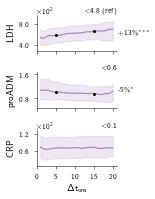

In [215]:
magnification = 0.77
ratio = 2.55/2.

CF.SetPlotParams(magnification=magnification, ratio=ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    print(var)  
    x, y_q1, y_mode, y_q3 = CF.moving_quantiles(Data, var, time_col, half_window=half_window, max_time=x_max_lim)
    time_mask = (x>=0) & (x<=x_max_display)
    x = x[time_mask]
    y_mode = y_mode[time_mask]
    y_q1 = y_q1[time_mask]
    y_q3 = y_q3[time_mask]
    
    y_min = min(y_q1)
    y_max = max(y_q3)
    y_range_w = abs(y_max-y_min)
    y_min = y_min - 0.25*y_range_w
    y_max = y_max + 0.25*y_range_w
    
    ax[i].plot(x, y_mode, '-', lw=lw, color=color)
    ax[i].fill_between(x, y_q1, y_q3, lw=lw, color=color, alpha=alpha_shade)
        
    ax[i].set_xticks([0, 5, 10, 15, 20, 25])
    ax[i].set_xlim([0, x_max_lim])

    ax[i].grid(False)
    yScalarFormatter = cc.ScalarFormatterClass()
    yScalarFormatter.set_powerlimits((0,0))
    ax[i].yaxis.set_major_formatter(yScalarFormatter)
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    #ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    if var in ref_values.keys():
        y_ref = ref_values[var]
        exp = int(np.log10(y_max))
        factor = y_ref/(10.**exp)
        val = 0
        d = 0
        while val==0:
            d += 1
            s_0 = '%%.%df' % d
            s = s_0 % factor
            val = float(s)
        ref_label = '$<$%s (ref)' % (s)
        if i>0:
            ref_label = '$<$%s' % (s)
        ax[i].text(1.0, 1.03, ref_label,
            horizontalalignment='right',
            verticalalignment='bottom',
            rotation='horizontal',
            transform=ax[i].transAxes,
            fontsize=ylabelsize)
        
    # Compute difference and significance between ages
    timepoint_1 = 5
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mode_1 = np.quantile(samples_1, 0.5)
    
    timepoint_2 = 15
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mode_2 = np.quantile(samples_2, 0.5)
    perc_change = 100*(mode_2-mode_1)/mode_1

    st_val, p_val = st.mannwhitneyu(samples_1, samples_2) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    #print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mode_1, mode_2], ls='', marker='.', ms=4., color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)

ax[i].set_xlabel('$\mathrm{\Delta t_{ons}}$')

saving_str = path_figures + name_feat_vs_time + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

# Covariates VS donset - Old

In [203]:
half_window = 5
max_time = 20 + half_window
x_max_display = 20
x_max_lim = x_max_display + 1

## Output

In [156]:
ms = 7.
capsize = 0.
lw = 1.2

time_col = 'delta_onset'
set_yticks = True
color_ref = 'black'

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5

alpha_shade = 0.2
magnification = 0.8

color = color_1

/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Ttest_indResult(statistic=1.0330528569826882, pvalue=0.30195941323825237) 

Ttest_indResult(statistic=2.6591610780179233, pvalue=0.008001538056906482) 

infectious_complications
Change: -0.06
Exact test: 0.011

Ttest_indResult(statistic=1.0029506233401495, pvalue=0.3162290243863723) 

Ttest_indResult(statistic=2.221650713388858, pvalue=0.026612086883315848) 

merged_death

No handles with labels found to put in legend.
No handles with labels found to put in legend.



Change: -0.06
Exact test: 0.032

Ttest_indResult(statistic=2.4583436488139205, pvalue=0.01419113167866405) 

IOT+death
Change: -0.07
Exact test: 0.019

Ttest_indResult(statistic=0.5193213613799933, pvalue=0.603719859714995) 



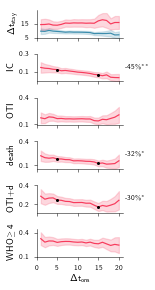

In [51]:
name_outcome_vs_time = 'outcome' + 'VSdonset'
y_variables = ['hospitalization_length', 'infectious_complications', 'IOT', 'merged_death', 'IOT+death', 'WHO=>4']
new_labels = ['$\mathrm{\Delta t_{stay}}$', 'IC', 'OTI', 'death', 'OTI+d', 'WHO$\ge 4$']
n_variables = len(y_variables)
stay_stratified_variables = ['delta_outcome_death', 'delta_outcome_discharge']
# data
Data = Data_V2.copy()

# drop na and remove outliers
Data = Data[y_variables+stay_stratified_variables+[time_col]]
ss = StandardScaler()
pt = PowerTransformer()
Data_norm = pt.fit_transform(ss.fit_transform(Data[['hospitalization_length']].values))
mask = np.abs(Data_norm.ravel()) > zscore_th
Data.loc[mask, 'hospitalization_length'] = np.nan

ratio = len(y_variables)/3.

#fig_width = 2.9 * magnification # width in inches
#fig_height = fig_width*ratio  # height in inches

width_correction = 0.96
height_correction = 0.92

CF.SetPlotParams(magnification=width_correction*magnification, ratio=height_correction*ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    if var=='hospitalization_length':
        x, y, y_err = CF.moving_average_donset(Data, 'delta_outcome_discharge', time_col, half_window=half_window, max_time=max_time)
        time_mask = x<=x_max_display
        x = x[time_mask]
        y = y[time_mask]
        y_err = y_err[time_mask]
        y_min = 0.9*min(y-y_err)
        y_max = 1.1*max(y+y_err)
        ax[i].plot(x, y, '-', lw=lw, color=light_blue_pal1)
        ax[i].fill_between(x, y - y_err, y + y_err, lw=lw, color=light_blue_pal1, alpha=0.2)

        x, y, y_err = CF.moving_average_donset(Data, 'delta_outcome_death', time_col, half_window=half_window, max_time=max_time)
        time_mask = x<=x_max_display
        x = x[time_mask]
        y = y[time_mask]
        y_err = y_err[time_mask]
        y_min = 0.9*min(y-y_err)
        y_max = 1.1*max(y+y_err)
        ax[i].plot(x, y, '-', lw=lw, color=red_purp_pal1)
        ax[i].fill_between(x, y - y_err, y + y_err, lw=lw, color=red_purp_pal1, alpha=0.2)
    else:
        x, y, y_err = CF.moving_average_donset(Data, var, time_col, half_window=half_window, max_time=max_time)
        time_mask = x<=x_max_display
        x = x[time_mask]
        y = y[time_mask]
        y_err = y_err[time_mask]
        y_min = 0.9*min(y-y_err)
        y_max = 1.1*max(y+y_err)
        ax[i].plot(x, y, '-', lw=lw, color=color)
        ax[i].fill_between(x, y - y_err, y + y_err, lw=lw, color=color, alpha=0.2)
    
    ax[i].set_xticks([0, 5, 10, 15, 20, 25])
    ax[i].set_xlim([0, x_max_lim])

    ax[i].grid(False)
    #yScalarFormatter = cc.ScalarFormatterClass(useMathText=True)
    #yScalarFormatter.set_powerlimits((0,0))
    #ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    #ax[i].yaxis.set_major_formatter(yScalarFormatter)
    
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    
    if i==0:
        ax[i].set_yticks([5, 15])
    elif i==1:
        ax[i].set_yticks([0.1, 0.3])
    elif i==2:
        ax[i].set_yticks([0.1, 0.4])
    elif i==3:
        ax[i].set_yticks([0.1, 0.4])
    elif i==4:
        ax[i].set_yticks([0.2, 0.4])
    elif i==5:
        ax[i].set_yticks([0.1, 0.4])
        
    ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    # Compute difference and significance at 5 and 15 days
    timepoint_1 = 5
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mean_1 = np.mean(samples_1)
    
    timepoint_2 = 15
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mean_2 = np.mean(samples_2)
    perc_change = 100*(mean_2-mean_1)/mean_1

    st_val, p_val = st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    
    #
    v1 = samples_1
    col1 = [sum(v1==0), sum(v1==1)]
    #
    v2 = samples_2
    col2 = [sum(v2==0), sum(v2==1)]
    #
    table12 = np.array([col1, col2]).T
    change12 = np.mean(v2)-np.mean(v1)
    if st.fisher_exact(table12)[1]<0.05:
        print(var)
        print('Change: %.2f' % change12)
        print('Exact test: %.3f' % st.fisher_exact(table12)[1])
        print('')
    
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mean_1, mean_2], ls='', marker='.', ms=4., color='black')
        #ax[i].vlines([agepoint_1, agepoint_2], ymin=[0, 0], ymax=[mean_1, mean_2], ls='--', lw=0.5, color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.0f$' % (abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)
        
ax[i].set_xlabel('$\mathrm{\Delta t_{ons}}$')

saving_str = path_figures + name_outcome_vs_time + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()

# Covariates VS Age - Old

In [186]:
half_window = 15
min_age_val = 20
max_age_val = 110

max_time = max_age_val + half_window
x_min_display = 40
x_min_lim = x_min_display - 3
x_max_display = 100
x_max_lim = x_max_display + 3

x_min_display_c = 30
x_min_lim_c = x_min_display_c - 3
x_max_display_c = 90
x_max_lim_c = x_max_display_c + 3

x_min_lim_combo = min([x_min_lim, x_min_lim_c])
x_max_lim_combo = max([x_max_lim, x_max_lim_c])

time_col = 'age'

## Output

In [189]:
ms = 7.
capsize = 0.
lw = 1.2

set_yticks = True

fontsize = 9
ylabelsize = 7
xlabelsize = 7 
tex = True
axes_lines_w = 0.5
lines_w = 0.5

alpha_shade = 0.2
magnification = 0.85

color = color_1

Ttest_indResult(statistic=-1.5527683990151588, pvalue=0.1210103514648877) 

Ttest_indResult(statistic=0.3697454695824614, pvalue=0.7116922228665807) 



/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Ttest_indResult(statistic=-1.2980537148694735, pvalue=0.19475752131557728) 

merged_death
Change: 0.16 (0.25 - 0.09)
Exact test: 0.000

/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc




Ttest_indResult(statistic=-5.40556597777527, pvalue=1.001861439822866e-07) 



/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


IOT+death
Change: 0.14 (0.31 - 0.17)
Exact test: 0.000

Ttest_indResult(statistic=-4.363705024020681, pvalue=1.519105825009979e-05) 



/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2023: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/opt/anaconda3/envs/py3_6_12/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2024: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Ttest_indResult(statistic=-1.3017250884210658, pvalue=0.1935501281243528) 



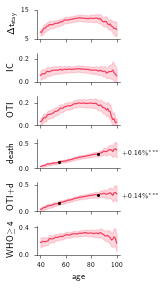

In [193]:
name_outcome_vs_time = 'outcome' + 'VSage_HalfWindow#%d' % half_window
y_variables = ['IOT', 'merged_death', 'IOT+death', 'WHO=>4', 'infectious_complications', 'hospitalization_length']
new_labels = ['OTI', 'death', 'OTI+d', 'WHO$\ge 4$', 'inf. compl.', '$\mathrm{\Delta t_{stay}}$']

y_variables = ['hospitalization_length', 'infectious_complications', 'IOT', 'merged_death', 'IOT+death', 'WHO=>4']
new_labels = ['$\mathrm{\Delta t_{stay}}$', 'IC', 'OTI', 'death', 'OTI+d', 'WHO$\ge 4$']
n_variables = len(y_variables)

# data
Data = Data_V2.copy()

# drop na and remove outliers
Data = Data[y_variables+[time_col]]
ss = StandardScaler()
pt = PowerTransformer()
#Data_norm = pt.fit_transform(ss.fit_transform(Data[['hospitalization_length']].values))
#mask = np.abs(Data_norm.ravel()) > zscore_th
#Data.loc[mask, 'hospitalization_length'] = np.nan

ratio = len(y_variables)/3.

#fig_width = 2.9 * magnification # width in inches
#fig_height = fig_width*ratio  # height in inches

width_correction = 0.96
height_correction = 0.86

CF.SetPlotParams(magnification=width_correction*magnification, ratio=height_correction*ratio, fontsize=fontsize, ylabelsize=ylabelsize,
                        xlabelsize=xlabelsize, tex=tex, axes_lines_w=axes_lines_w, lines_w=lines_w, legendmarker=True)
fig, ax =  plt.subplots(n_variables, 1, sharex=True)

for i, var in enumerate(y_variables):
    x, y, y_err = CF.moving_average_2(Data, var, time_col, half_window=half_window, min_time=min_age_val, max_time=max_age_val)
    time_mask = (x>=x_min_display) & (x<=x_max_display)
    x = x[time_mask]
    y = y[time_mask]
    y_correction = 0.035
    if var=='merged_death':
        y = y+y_correction
    y_err = y_err[time_mask]
    y_min = 0.9*min(y-y_err)
    y_max = 1.1*max(y+y_err)
    
    ax[i].plot(x, y, '-', lw=lw, color=color)
    ax[i].fill_between(x, y - y_err, y + y_err, lw=lw, color=color, alpha=0.2)
    ax[i].set_xticks([40, 60, 80, 100])
    #ax[i].set_xlim([0, x_max_lim])

    ax[i].grid(False)
    #yScalarFormatter = cc.ScalarFormatterClass(useMathText=True)
    #yScalarFormatter.set_powerlimits((0,0))
    #ax[i].yaxis.set_major_locator(plt.MaxNLocator(prune='both', nbins=1))
    #ax[i].yaxis.set_major_formatter(yScalarFormatter)
    
    ax[i].set_ylabel(new_labels[i])
    ax[i].set_ylim([y_min, y_max])
    ax[i].set_ylabel(new_labels[i])
    

    if i==0:
        ax[i].set_yticks([5, 15])
        ax[i].set_ylim([5, 15])
    elif i==1:
        ax[i].set_yticks([0, 0.2])
        ax[i].set_ylim([0, 0.25])
    elif i==2:
        ax[i].set_yticks([0, 0.2])
        ax[i].set_ylim([0, y_max])
    elif i==3:
        ax[i].set_yticks([0, 0.5])
    elif i==4:
        ax[i].set_yticks([0, 0.5])
    elif i==5:
        ax[i].set_yticks([0, 0.4])
        ax[i].set_ylim([0, y_max])
        
    #ax[i].legend(bbox_to_anchor=(1.05, 0.77), loc="lower right", ncol=1, fontsize=ylabelsize)
    
    # Compute difference and significance between ages
    timepoint_1 = 55
    Data_local = Data[[var, time_col]].copy().dropna()
    mask_1 = (Data_local[time_col].values>=timepoint_1-half_window) & (Data_local[time_col].values<=timepoint_1+half_window)
    samples_1 = Data_local.loc[mask_1, var].values
    mean_1 = np.mean(samples_1)
    
    timepoint_2 = 85
    mask_2 = (Data_local[time_col].values>=timepoint_2-half_window) & (Data_local[time_col].values<=timepoint_2+half_window)
    samples_2 = Data_local.loc[mask_2, var].values
    mean_2 = np.mean(samples_2)
    perc_change = 100*(mean_2-mean_1)/mean_1
    
    #
    v1 = samples_1
    col1 = [sum(v1==0), sum(v1==1)]
    #
    v2 = samples_2
    col2 = [sum(v2==0), sum(v2==1)]
    #
    table12 = np.array([col1, col2]).T
    change12 = np.mean(v2)-np.mean(v1)
    if st.fisher_exact(table12)[1]<0.05:
        print(var)
        print('Change: %.2f (%.2f - %.2f)' % (change12, np.mean(v2), np.mean(v1)))
        print('Exact test: %.3f' % st.fisher_exact(table12)[1])
        print('')
        
    if var=='merged_death':
        mean_1, mean_2 = mean_1+y_correction, mean_2+y_correction
        
    st_val, p_val = st.fisher_exact(table12) #st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit')
    print(st.ttest_ind(samples_1, samples_2, equal_var=False, nan_policy='omit'), '\n')
    if p_val<0.05:
        ax[i].plot([timepoint_1, timepoint_2], [mean_1, mean_2], ls='', marker='.', ms=4., color='black')
        #ax[i].vlines([agepoint_1, agepoint_2], ymin=[0, 0], ymax=[mean_1, mean_2], ls='--', lw=0.5, color='black')
        p_val_not = '$^{*\,\,}$'
        if p_val<0.01:
            p_val_not = '$^{**\,}$'
        if p_val<0.001:
            p_val_not = '$^{***}$'
        if perc_change<0:
            s = '-'
        else:
            s = '+'
        s = s + '$%.2f$' % change12 #(abs(perc_change))
        s = s + '\%' + p_val_not
        ax[i].text(1.02, 0.5, s,
                   horizontalalignment='left',
                   verticalalignment='center',
                   rotation='horizontal',
                   transform=ax[i].transAxes,
                   fontsize=ylabelsize)
        
ax[i].set_xlabel('age')

saving_str = path_figures + name_outcome_vs_time + '.pdf'
plt.savefig(saving_str, bbox_inches='tight')# dpi=1000,
plt.show()